# Regression Project

In this project, your goal is to build regression models of housing prices. The models should learn from data and be able to predict the median house price in a district (which is a population of 600 to 3000 people), given some predictor variable

Das Vorgehen in diesem Notebook orientiert sich am Data Science Lifecycle.
Es wird eine Modellpräzision von > 70% gewünscht. Das bedeutet, dass der R-squared Wert des besten Modells >0,7 sein soll.

## Python Setup

Zunächst werden mit der Import Methode wichtige Python Bibliotheken importiert.

In [163]:
import pandas as pd
import numpy as np 

import seaborn as sns
sns.set_theme(style='ticks')

import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.formula.api as smf
import statsmodels.api as sm
import statsmodels.gam.api as smg

from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
import sklearn.metrics as skm
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.preprocessing import SplineTransformer
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline

import plotly.express as px

## Datenaufbereitung

### Daten laden
Importieren der Daten aus der CSV in Github und Erstellung eines Pandas Dataframes zur Bearbeitung und Verwendung der Daten in diesem Notebook.

In [218]:
GIT = "https://raw.githubusercontent.com/jan-kirenz/project-annikas428/main/"
DATA = "project_data.csv"
TOKEN = "?token=GHSAT0AAAAAABPURMBOEW2WS3JEBXGI5TPAYPJRBIQ"

df_initial = pd.read_csv(GIT + DATA + TOKEN)

### Inspect Data

Im ersten Schritt ist es wichtig, sich einen Überblick über die Daten zu verschaffen. Begonnen wird mit einer Anzeige einiger Datensätze.

In [4]:
df_initial

longitude  latitude housing_median_age  total_rooms  total_bedrooms  \
0        -122.23     37.88          41.0years          880           129.0   
1        -122.22     37.86               21.0         7099          1106.0   
2        -122.24     37.85               52.0         1467           190.0   
3        -122.25     37.85               52.0         1274           235.0   
4        -122.25     37.85               52.0         1627           280.0   
...          ...       ...                ...          ...             ...   
20635    -121.09     39.48               25.0         1665           374.0   
20636    -121.21     39.49               18.0          697           150.0   
20637    -121.22     39.43               17.0         2254           485.0   
20638    -121.32     39.43               18.0         1860           409.0   
20639    -121.24     39.37               16.0         2785           616.0   

       population  households  median_income median_house_value  \
0             322         126         8.3252          452600.0$   
1            2401        1138         8.3014           358500.0   
2             496         177         7.2574           352100.0   
3             558         219         5.6431           341300.0   
4             565         259         3.8462           342200.0   
...           ...         ...            ...                ...   
20635         845         330         1.5603            78100.0   
20636         356         114         2.5568            77100.0   
20637        1007         433         1.7000            92300.0   
20638         741         349         1.8672            84700.0   
20639        1387         530         2.3886            89400.0   

      ocean_proximity price_category  
0            NEAR BAY          above  
1            NEAR BAY          above  
2            NEAR BAY          above  
3            NEAR BAY          above  
4            NEAR BAY          above  
...               ...            ...  
20635          INLAND          above  
20636          INLAND          above  
20637          INLAND          above  
20638          INLAND          above  
20639          INLAND          above  

[20640 rows x 11 columns]

Beim Sichten der Datensätze fällt auf, dass im ersten Datensatz zwei Unstimmigkeiten im Vergleich zu den anderen Datensätzen vorliegen: <br>
_median_house_value_ ist nur hier mit der Währung Dollar angegeben und hinter _housing_median_age_ steht der Zusatz "years". 

Nun folgt Pandas Dataframe Info Methode. Diese zeigt die Variablen und deren Datentypen, sowie die Anzahl der non-null values je Spalte an. 

In [3]:
df_initial.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  object 
 3   total_rooms         20640 non-null  int64  
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  int64  
 6   households          20640 non-null  int64  
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  object 
 9   ocean_proximity     20640 non-null  object 
 10  price_category      20640 non-null  object 
dtypes: float64(4), int64(3), object(4)
memory usage: 1.7+ MB


Die Variablen _housing_median_age_ und und _median_house_value_ wurden als Datentyp _object_ definiert. Dies muss genauer untersucht werden, da bei einer Jahreszahl bzw. einem monetären Wert ein numerischer Datentyp (int oder float) angemessener ist. Die Ursache hierfür ist auf die Zusatzangaben "$" und "years" zurückzuführen. <br>
Die Varialben _ocean_proximity_ und _price_category_ sind keine numerischen sondern kategoriale Datentypen. Diese lassen sich jeweils in einer internen Rangordnung anordnen. Sie sind daher ordinal. Der richtige Datentyp hierfür ist _category_. Die Transformation der Datentypen erfolgt in Kapitel "Data Transformation". <br>
Neben den Datentypen wird auch die Anzahl der non-null values je Variable angezeigt. Hier haben alle Variablen eine Anzahl von 20640 non-null values. Lediglich die Variable _total_bedrooms_ liegt unter diesem Wert. Dies lässt darauf schließen, dass hier einige Datensätze keinen Wert haben. Dies gilt es im Folgenden genauer zu untersuchen.

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
price_category          0
dtype: int64


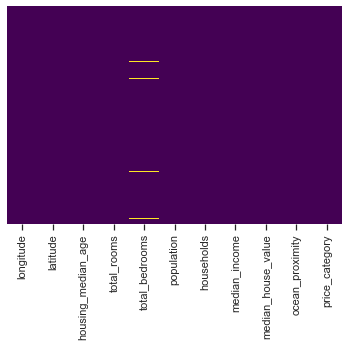

In [75]:
# show missing values -if present - in yellow
sns.heatmap(df_initial.isnull(), 
            yticklabels=False,
            cbar=False, 
            cmap='viridis');

print(df_initial.isnull().sum())

Wie bereits vermutet, enthält die Variable _total_bedrooms_ 207 null values. Die Abbildung visualisiert diese nicht befüllten Datensätze und deren Verteilung im Datenset in gelb. Die null-values sind zufällig im Datenset verteilt. Da das Datenset über 20000 Datensätze enthält, werden die Zeilen mit den null-values im Kapitel Transform Data entfernt. Alternativ wäre auch eine Belegung der null-values beispielsweise mit dem Durchschnittswert der Variable möglich. Darauf wird hier jedoch verzichtet, genug andere Datensätze vorliegen.

### Datentransformation
#### Entfernung der null values

In [219]:
# drop rows with missing values
df = df_initial.dropna()
print(df.isnull().sum())

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
price_category        0
dtype: int64


#### Entfernung unwichtiger Features
Das Feature -price_category_ wird entfernt, da es sich direkt aus der Variablen _median_house_value_ ableitet und daher nicht zur Berechnung des Wertes genutzt werden darf. Dieses Feature wird im Notebook Classification als abhängige Variable genutzt.

In [220]:
#drop irrelevant features
df = df.drop(['price_category'], axis=1)

#### Konvertierung von Datentypen
Die mithilfe der info() Methode identifizierten Features, welche eine Datentyp Konvertierung benötigen, werden nun bearbeitet.

In [221]:
# Convert data types Ocean_Proximity and Price_Category to Data Type "Category" as they are categorical variables (ordinal)
df.ocean_proximity = df.ocean_proximity.astype('category')

# Housing_Median_Age and Median_House_Value are actually int64 values, but pandas did not get this because of signs like '€'
df.housing_median_age = df.housing_median_age.str.replace('years', '', regex=False)
df.median_house_value = df.median_house_value.str.replace('$', '', regex=False)
df.housing_median_age = pd.to_numeric(df.housing_median_age, errors='coerce').astype('int64')
df.median_house_value = pd.to_numeric(df.median_house_value, errors='coerce').astype('float64')
df.total_bedrooms = df.total_bedrooms.astype('int64')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20433 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   longitude           20433 non-null  float64 
 1   latitude            20433 non-null  float64 
 2   housing_median_age  20433 non-null  int64   
 3   total_rooms         20433 non-null  int64   
 4   total_bedrooms      20433 non-null  int64   
 5   population          20433 non-null  int64   
 6   households          20433 non-null  int64   
 7   median_income       20433 non-null  float64 
 8   median_house_value  20433 non-null  float64 
 9   ocean_proximity     20433 non-null  category
dtypes: category(1), float64(4), int64(5)
memory usage: 1.6 MB


longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                  41          880             129   
1    -122.22     37.86                  21         7099            1106   
2    -122.24     37.85                  52         1467             190   
3    -122.25     37.85                  52         1274             235   
4    -122.25     37.85                  52         1627             280   

   population  households  median_income  median_house_value ocean_proximity  
0         322         126         8.3252            452600.0        NEAR BAY  
1        2401        1138         8.3014            358500.0        NEAR BAY  
2         496         177         7.2574            352100.0        NEAR BAY  
3         558         219         5.6431            341300.0        NEAR BAY  
4         565         259         3.8462            342200.0        NEAR BAY

Mithilfe der string replace Methode werrden die zuvor identifizierten Zeichen "years" und "$" entfernt. Anschließend ist eine Transformation der Features in integer bzw. float Werte möglich. Für _housing_median_age_ wird integer gewählt, da die Jahreszahlen als Ganze Zahlen also discrete Werte angegeben sind. <br>
Für _median_house_value_ wird der Datentyp float benötigt, da die Ergebnisse einer linearen Regression stehts continous sind.

#### Hinzufügen neuer Features

In [222]:
df = df.assign(people_per_household=lambda df: df.population / df.households)
df = df.assign(rooms_per_household=lambda df: df.total_rooms / df.households)
df = df.assign(bedrooms_per_people=lambda df: df.total_bedrooms / df.population)
df = df.assign(bedrooms_per_rooms=lambda df: df.total_bedrooms / df.total_rooms)

Diese Features werden dem Datenset hinzugefügt, in der Hoffnung, dass diese für die Verwendung in den Modellen nützlich sein könnten. Untersucht wird dies im Kapitel EDA.

## Datensplit
Split des Datensets in 80% Trainingsdaten und 20% Testdaten. Die Testdaten werden anschließend bis zur finalen Evaluation der besten Modelle nicht verwendet.

In [345]:
train_dataset = df.sample(frac=0.8, random_state=0) 
test_dataset = df.drop(train_dataset.index)

train_dataset

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
14185    -117.08     32.70                  37         2176             418   
6125     -117.91     34.11                  20         3158             684   
14095    -117.10     32.75                  11         2393             726   
14359    -117.22     32.74                  52         1260             202   
18004    -121.99     37.29                  32         2930             481   
...          ...       ...                 ...          ...             ...   
6168     -117.93     34.09                  35         1891             353   
4174     -118.21     34.10                  36         2000             533   
3593     -118.48     34.24                  32         2621             412   
5366     -118.39     34.04                  44         1873             286   
17879    -122.00     37.40                  17         5121            1017   

       population  households  median_income  median_house_value  \
14185        1301         375         2.8750             98900.0   
6125         2396         713         3.5250            153000.0   
14095        1905         711         1.3448             91300.0   
14359         555         209         7.2758            345200.0   
18004        1336         481         6.4631            344100.0   
...           ...         ...            ...                 ...   
6168         1093         382         4.0167            165500.0   
4174         1234         535         3.7437            241700.0   
3593         1285         414         6.6537            267600.0   
5366          635         283         5.5951            461300.0   
17879        1470         968         2.9706             81300.0   

      ocean_proximity  people_per_household  rooms_per_household  \
14185      NEAR OCEAN              3.469333             5.802667   
6125        <1H OCEAN              3.360449             4.429173   
14095      NEAR OCEAN              2.679325             3.365682   
14359      NEAR OCEAN              2.655502             6.028708   
18004       <1H OCEAN              2.777547             6.091476   
...               ...                   ...                  ...   
6168        <1H OCEAN              2.861257             4.950262   
4174        <1H OCEAN              2.306542             3.738318   
3593        <1H OCEAN              3.103865             6.330918   
5366        <1H OCEAN              2.243816             6.618375   
17879       <1H OCEAN              1.518595             5.290289   

       bedrooms_per_people  bedrooms_per_rooms  
14185             0.321291            0.192096  
6125              0.285476            0.216593  
14095             0.381102            0.303385  
14359             0.363964            0.160317  
18004             0.360030            0.164164  
...                    ...                 ...  
6168              0.322964            0.186674  
4174              0.431929            0.266500  
3593              0.320623            0.157192  
5366              0.450394            0.152696  
17879             0.691837            0.198594  

[16346 rows x 14 columns]

## Deskriptive Statistik

### Kennzahlenanalyse numerischer Variablen

Mithilfe der describe() Methode werden die wichtigsten Kennzahlen numerischer Variablen (bspw. Durchschnitt, min und max Werte) ausgegeben.

In [177]:
#summary statistics for all numerical columns
train_dataset.describe().T

count           mean            std           min  \
longitude             16346.0    -119.564154       2.002618   -124.350000   
latitude              16346.0      35.630318       2.138574     32.550000   
housing_median_age    16346.0      28.664505      12.556764      1.000000   
total_rooms           16346.0    2622.235776    2169.548287     11.000000   
total_bedrooms        16346.0     535.281659     418.469078      3.000000   
population            16346.0    1416.087055    1103.842065      3.000000   
households            16346.0     496.758167     379.109535      3.000000   
median_income         16346.0       3.869337       1.902228      0.499900   
median_house_value    16346.0  206916.154411  115676.394484  14999.000000   
people_per_household  16346.0       3.089529      11.525259      0.692308   
rooms_per_household   16346.0       5.423747       2.160962      0.846154   
bedrooms_per_people   16346.0       0.403370       0.223233      0.000670   
bedrooms_per_rooms    16346.0       0.213188       0.057891      0.100000   

                                25%            50%            75%  \
longitude               -121.790000    -118.490000    -118.000000   
latitude                  33.930000      34.250000      37.710000   
housing_median_age        18.000000      29.000000      37.000000   
total_rooms             1448.000000    2119.000000    3120.750000   
total_bedrooms           296.000000     432.500000     644.000000   
population               784.250000    1164.000000    1711.000000   
households               280.000000     408.000000     600.000000   
median_income              2.555675       3.533200       4.744225   
median_house_value    119300.000000  179700.000000  265900.000000   
people_per_household       2.428850       2.816514       3.282584   
rooms_per_household        4.443697       5.230149       6.051703   
bedrooms_per_people        0.315480       0.372646       0.443446   
bedrooms_per_rooms         0.175591       0.203263       0.239668   

                                max  
longitude               -114.470000  
latitude                  41.950000  
housing_median_age        52.000000  
total_rooms            39320.000000  
total_bedrooms          6445.000000  
population             28566.000000  
households              6082.000000  
median_income             15.000100  
median_house_value    500001.000000  
people_per_household    1243.333333  
rooms_per_household       62.422222  
bedrooms_per_people        8.750000  
bedrooms_per_rooms         1.000000

Der Durchschnitt (mean) der Variablen _housing_median_age_ über alle Datensätze beträgt 28,64 Jahre. Die Standardabweichung, also die durchschnittliche Abweichung der Werte vom Durchschnitt, beträgt 12,56 Jahre. Das Minimum liegt bei 1 Jahr, das Maximum der 52 Jahren. 25% der Datensätze liegen unter 18 Jahren (1. Quartil). 50% zwischen unter 29 Jahren (2. Quartil) und 75% zwischen unter 37 Jahren (3. Quartil).<br>
Im Durchschnitt beträgt der Wert _people_per_household_ 3,09. Die durchschnittliche Abweichung von diesem Wert beträgt 11,53. Das Minimum liegt bei 0,69 und das Maximum bei 1243 Personen pro Haushalt. 25% der Datensätze liegen zwischen 0,69 und 2,43. 50% unter 2,82 und 75% der Datensätze unter 3,28 Personen pro Haushalt.

In [118]:
print(train_dataset.quantile(0.99, interpolation='nearest'))

longitude                 -116.290000
latitude                    40.630000
housing_median_age          52.000000
total_rooms              11021.000000
total_bedrooms            2208.000000
population                5723.000000
households                1955.000000
median_income               10.557500
median_house_value      500001.000000
people_per_household         5.286920
rooms_per_household         10.500000
bedrooms_per_people          0.941606
bedrooms_per_rooms           0.407472
Name: 0.99, dtype: float64


Die Quantile() Methode gibt für jede Variable einen Wert an, unter welchem (in diesem Beispiel) 99% der Datensätze liegen. <br>
Beispielsweise liegen 99% der Datensätze unter einer Anzahl _total_rooms_ in Höhe von 11021. <br>
99% der Distrikte haben eine _population_ unter 5723 Einwohnern. <br>
Im Nachfolgenden werden einige mögliche Ausreiser identifiziert.

Dieser Datensatz steht für ein Distrikt, welches aus nur 1 Haushalt besteht. In diesem Haushalt leben 13 Leute, die sich 8 Räume, wovon einer ein Schlafzimmer ist, teilen. Der Wert des Hauses beträgt 500001 $. <br>
Dies erscheint etwas unwahrscheinlich. Womöglich handelt es sich um eine Falscheingabe. Der Datensatz wird daher entfernt.

In [178]:
train_dataset.loc[train_dataset.people_per_household > 100]

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
19006    -121.98     38.32                  45           19               5   
16669    -120.70     35.32                  46          118              17   
3364     -120.51     40.41                  36           36               8   

       population  households  median_income  median_house_value  \
19006        7460           6        10.2264            137500.0   
16669        6532          13         4.2639            350000.0   
3364         4198           7         5.5179             67500.0   

      ocean_proximity  people_per_household  rooms_per_household  \
19006          INLAND           1243.333333             3.166667   
16669      NEAR OCEAN            502.461538             9.076923   
3364           INLAND            599.714286             5.142857   

       bedrooms_per_people  bedrooms_per_rooms  
19006             0.000670            0.263158  
16669             0.002603            0.144068  
3364              0.001906            0.222222

Mehr als 50 Leute in einem Haushalten wirken sehr unrealistisch. 99% der Datensätze liegen unter einem Wert von 5,39 Personen pro Haushalt. Daher werden diese Datensätze als Ausreiser identifiziert.

In [179]:
train_dataset.loc[train_dataset.bedrooms_per_people > 8]

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
11862    -121.25     40.27                  25          958             245   

       population  households  median_income  median_house_value  \
11862          28          16          2.625             67500.0   

      ocean_proximity  people_per_household  rooms_per_household  \
11862          INLAND                  1.75               59.875   

       bedrooms_per_people  bedrooms_per_rooms  
11862                 8.75            0.255741

Auch diese Werte liegen weit über dem 99% Perzentil der Varialben _bedrooms_per_people_ und werden daher als Ausreiser entfernt. Zwei dieser Werte sind auch bereits _rooms_per_household_ Ausreiser.

In [181]:
train_dataset.loc[train_dataset.rooms_per_household > 55]

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
12447    -114.49     33.97                  17         2809             635   
11862    -121.25     40.27                  25          958             245   
1913     -120.06     39.01                  19         2967             528   

       population  households  median_income  median_house_value  \
12447          83          45         1.6154             87500.0   
11862          28          16         2.6250             67500.0   
1913          112          48         4.0714            437500.0   

      ocean_proximity  people_per_household  rooms_per_household  \
12447          INLAND              1.844444            62.422222   
11862          INLAND              1.750000            59.875000   
1913           INLAND              2.333333            61.812500   

       bedrooms_per_people  bedrooms_per_rooms  
12447             7.650602            0.226059  
11862             8.750000            0.255741  
1913              4.714286            0.177958

In [301]:
#drop people per household outliers
train_dataset = train_dataset.drop([3364, 16669, 19006])
#drop bedroooms per people outliers
train_dataset = train_dataset.drop([11862])
#drop rooms per household_outliers
train_dataset = train_dataset.drop([1913, 12447])

In [187]:
#summary statistics for all numerical columns
train_dataset.describe().T

count           mean            std           min  \
longitude             16340.0    -119.564056       2.002423   -124.350000   
latitude              16340.0      35.629491       2.138024     32.550000   
housing_median_age    16340.0      28.663525      12.556964      1.000000   
total_rooms           16340.0    2622.775949    2169.626947     11.000000   
total_bedrooms        16340.0     535.390208     418.478468      3.000000   
population            16340.0    1415.480171    1101.940296      3.000000   
households            16340.0     496.932313     379.070022      3.000000   
median_income         16340.0       3.869024       1.901773      0.499900   
median_house_value    16340.0  206921.906977  115662.820190  14999.000000   
people_per_household  16340.0       2.946757       1.291597      0.692308   
rooms_per_household   16340.0       5.413407       2.023690      0.846154   
bedrooms_per_people   16340.0       0.402226       0.202989      0.011222   
bedrooms_per_rooms    16340.0       0.213188       0.057896      0.100000   

                                25%            50%            75%  \
longitude               -121.790000    -118.490000    -118.000000   
latitude                  33.930000      34.250000      37.710000   
housing_median_age        18.000000      29.000000      37.000000   
total_rooms             1449.000000    2119.500000    3121.250000   
total_bedrooms           296.000000     433.000000     644.000000   
population               785.000000    1164.000000    1711.000000   
households               280.000000     408.000000     600.250000   
median_income              2.555600       3.533000       4.744075   
median_house_value    119300.000000  179700.000000  265900.000000   
people_per_household       2.428869       2.816514       3.282433   
rooms_per_household        4.443662       5.229614       6.050922   
bedrooms_per_people        0.315537       0.372646       0.443428   
bedrooms_per_rooms         0.175588       0.203260       0.239666   

                                max  
longitude               -114.470000  
latitude                  41.950000  
housing_median_age        52.000000  
total_rooms            39320.000000  
total_bedrooms          6445.000000  
population             28566.000000  
households              6082.000000  
median_income             15.000100  
median_house_value    500001.000000  
people_per_household      83.171429  
rooms_per_household       52.848214  
bedrooms_per_people        7.925926  
bedrooms_per_rooms         1.000000

### Analyse kategorialer Variablen

In [227]:
# summary statistics for all categorical columns
train_dataset.describe(include=['category']).transpose()

count unique        top  freq
ocean_proximity  16340      4  <1H OCEAN  7216

Die Variable ocean_proximity besitzt 5 Ausprägungen, wovon die Ausprägung _<1H OCEAN_ mit einer Anzhl von 7215 am häufigsten vorkommt.

In [91]:
train_dataset['ocean_proximity'].value_counts()

<1H OCEAN     7215
INLAND        5221
NEAR OCEAN    2108
NEAR BAY      1796
ISLAND           5
Name: ocean_proximity, dtype: int64

Hier wird die Häufigkeit einzelner Ausprägungen von _ocean_proximity_ dargestellt. Die Ausprägung _ISLAND_ kommt über das gesamte Datenset mit über 20000 Datensätzen nur fünfmal vor. In Relation zur Gesamtanzahl der Datensätzen ist dies sehr wenig, wodurch die Aussagekraft dieser Ausprägung vermutlich eher gering ist. Daher werden die Datensätze mit Ausprägung _ISLAND_ mit der Ausprägung _NEAR OCEAN_ vereint.


In [225]:
train_dataset.loc[train_dataset.ocean_proximity == 'ISLAND']

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
8318    -118.48     33.43                  29          716             214   
8316    -118.32     33.33                  52         2127             512   
8315    -118.33     33.34                  52         2359             591   
8314    -118.32     33.35                  27         1675             521   
8317    -118.32     33.34                  52          996             264   

      population  households  median_income  median_house_value  \
8318         422         173         2.6042            287500.0   
8316         733         288         3.3906            300000.0   
8315        1100         431         2.8333            414700.0   
8314         744         331         2.1579            450000.0   
8317         341         160         2.7361            450000.0   

     ocean_proximity  people_per_household  rooms_per_household  \
8318          ISLAND              2.439306             4.138728   
8316          ISLAND              2.545139             7.385417   
8315          ISLAND              2.552204             5.473318   
8314          ISLAND              2.247734             5.060423   
8317          ISLAND              2.131250             6.225000   

      bedrooms_per_people  bedrooms_per_rooms  
8318             0.507109            0.298883  
8316             0.698499            0.240715  
8315             0.537273            0.250530  
8314             0.700269            0.311045  
8317             0.774194            0.265060

In [302]:
# write out a dict with the mapping of old to new
remap_cat_dict = {
    'NEAR OCEAN': 'NEAR OCEAN',
    'NEAR BAY': 'NEAR BAY',
    'ISLAND': 'NEAR OCEAN',
    'INLAND': 'INLAND',
    '<1H OCEAN': '<1H OCEAN' }

train_dataset.ocean_proximity = train_dataset.ocean_proximity.map(remap_cat_dict).astype('category')

## Exploratory Data Anaysis

Dieses Kapitel dient der ausführlichen Datenanalyse der Testdaten. Hierfür werden vor allem geeignete Visualisierungen in Form von Diagrammen verwendet.

### erster Überblick

In [29]:
# summary statistics for all numerical columns
round(train_dataset.describe(),2).transpose()

count       mean        std       min        25%  \
longitude             16338.0    -119.56       2.00   -124.35    -121.79   
latitude              16338.0      35.63       2.14     32.54      33.93   
housing_median_age    16338.0      28.64      12.62      1.00      18.00   
total_rooms           16338.0    2619.90    2138.55      2.00    1449.25   
total_bedrooms        16338.0     534.71     415.05      2.00     296.00   
population            16338.0    1412.56    1076.28      3.00     786.00   
households            16338.0     496.09     375.44      2.00     280.00   
median_income         16338.0       3.88       1.92      0.50       2.57   
median_house_value    16338.0  206894.94  115589.45  14999.00  119400.00   
people_per_household  16338.0       2.95       1.24      0.69       2.43   
rooms_per_household   16338.0       5.42       2.07      0.89       4.45   
bedrooms_per_people   16338.0       0.40       0.21      0.01       0.32   
bedrooms_per_rooms    16338.0       0.21       0.06      0.10       0.18   

                            50%        75%        max  
longitude               -118.48    -118.00    -114.31  
latitude                  34.25      37.71      41.95  
housing_median_age        29.00      37.00      52.00  
total_rooms             2118.00    3123.00   37937.00  
total_bedrooms           433.00     643.00    5471.00  
population              1160.00    1706.00   16122.00  
households               407.00     599.00    5189.00  
median_income              3.54       4.74      15.00  
median_house_value    179500.00  265200.00  500001.00  
people_per_household       2.82       3.29      83.17  
rooms_per_household        5.23       6.06      61.81  
bedrooms_per_people        0.37       0.44       7.93  
bedrooms_per_rooms         0.20       0.24       1.00

In [38]:
import plotly.graph_objects as go

fig = go.Figure(data=go.Scattergeo(
        lon = train_dataset['longitude'],
        lat = train_dataset['latitude'],
        text = 'median house value in district: ' + train_dataset['median_house_value'].astype(str) + '$',
        marker_color = train_dataset['median_house_value'], marker_size=2, marker_colorscale = 'Inferno', marker_colorbar= {'title': 'Median House Value'}
        ))

fig.update_layout(
        title = 'Median House Value per District in California',
        geo_scope='usa',
    )
fig.show()

Die Datensätze stammen alle aus Kalifornien, USA. <br>
Die Werte Longitude und Latitude unterscheiden sich daher kaum, wie sich auch bereits im Kapitel deskriptive Statistik gezeigt hat.
Daher sind sie als Feature eher ungeeignet. <br> 
Allerdings scheint die Entfernung zum Ozean eine wichtige Rolle im Bezug auf den _median_house_value_ zu spielen.
Ocean_proximity scheint daher als feature interessant und sollte genauer untersucht werden.

In [189]:
train_dataset = train_dataset.drop(['longitude', 'latitude'], axis = 1)

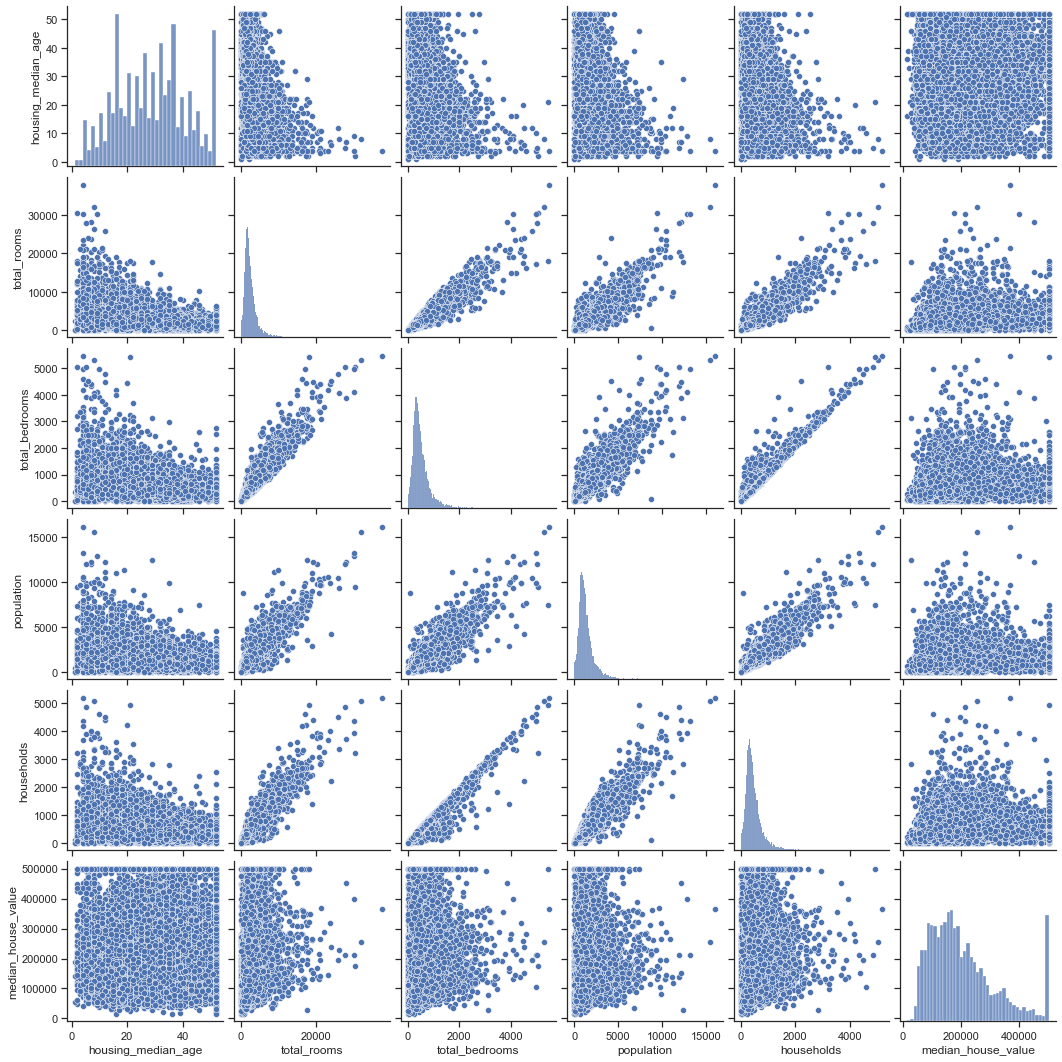

In [40]:
sns.pairplot(train_dataset[['housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_house_value']])

Die hier abgebildeten, unabhängigen Variablen weisen eine starke Korrelation untereinander auf (bis auf housing_median_age). <br>
In Bezug auf die abhängige Variable _median_house_value_ zeigen die Plots zunächst keinen starken Zusammenhang. <br>
Interessant sieht das Histogramme von _median_house_value_ aus, da es am äußeren rechten Rand nochmal hohe Häufigkeiten haben. Dieses Histogramme wird später nochmal genauer analysisiert.

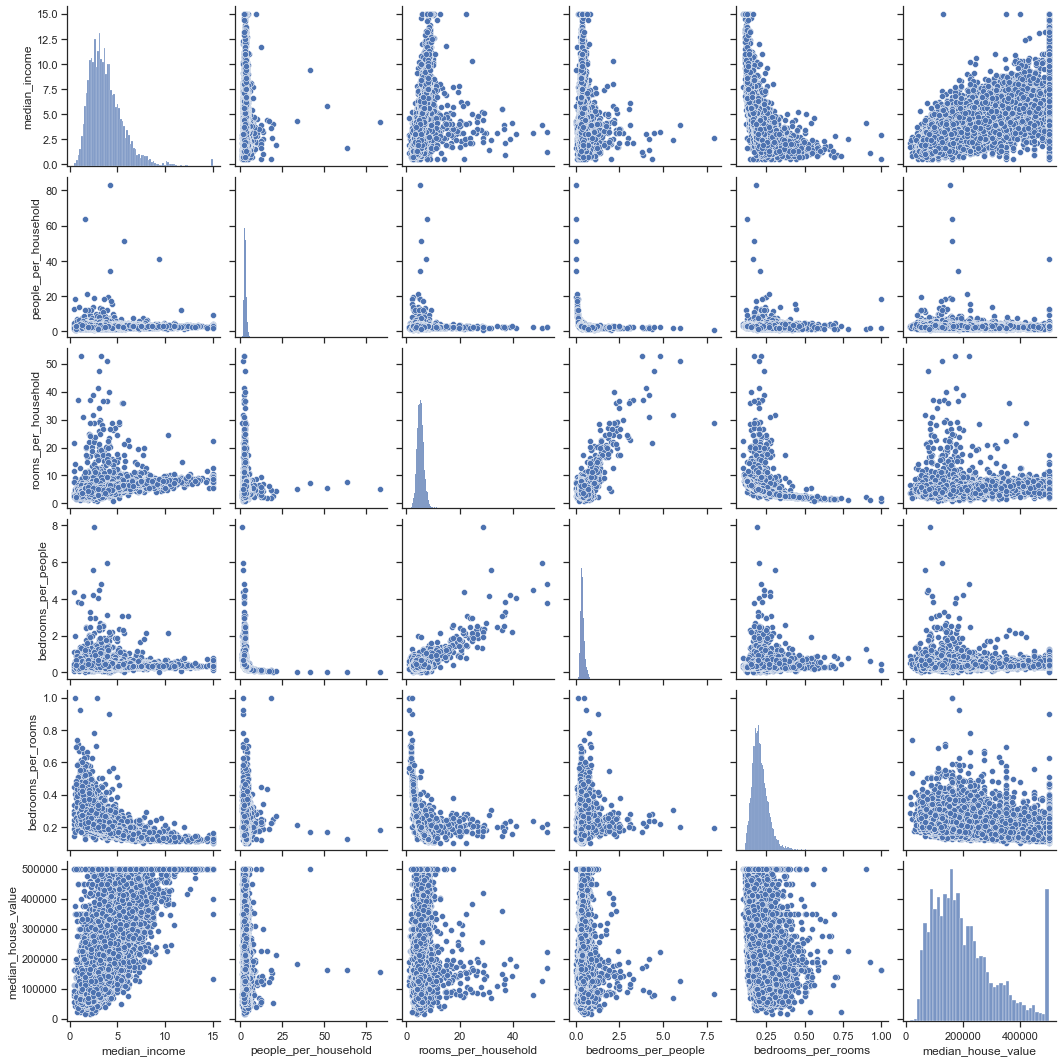

In [296]:
sns.pairplot(train_dataset[['median_income', 'people_per_household', 'rooms_per_household', 'bedrooms_per_people', 'bedrooms_per_rooms', 'median_house_value']]);

Zwischen _median_income_ und _median_house_value_ ist ein Zusammenhang erkennbar. Auch das Histogramm von _median_income_ zeigt eine hohe Säule am rechten Rand. <br>
Auch für die selbst definierten Variablen ist es schwierig, ein linearen Zusammenhang zu _median_house_value_ zu erkennen.

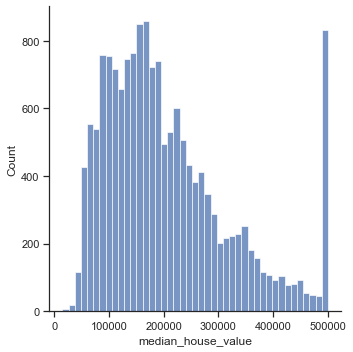

In [46]:
fig = sns.displot(data= train_dataset, x='median_house_value')

Die Verteilung von Median_House_value nicht normalverteilt, rechts im hohen Preissegment ist die Häufigkeit nochmal extrem hoch. Über 500000$ exisiteren keine weiteren Hauswerte. Möglicherweise wurde der Datensatz mit Werten über 500000$ abgeschnitten und für alle höheren Werte, der Wert 500000$ gesetzt.

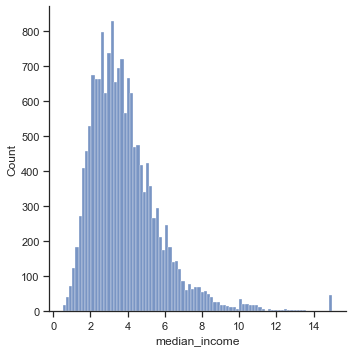

In [47]:
fig = sns.displot(data= train_dataset, x='median_income')

Womöglich wurde auch die Variable _median_income_ nach oben abgeschnitten.

### Korrelationsanalyse

In [303]:
# Create correlation matrix for numerical variables
corr_matrix = train_dataset.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value      1.000000
median_income           0.692088
rooms_per_household     0.176506
total_rooms             0.130850
housing_median_age      0.105574
bedrooms_per_people     0.077531
households              0.063122
total_bedrooms          0.047633
population             -0.026782
longitude              -0.043011
latitude               -0.147308
people_per_household   -0.157646
bedrooms_per_rooms     -0.253006
Name: median_house_value, dtype: float64

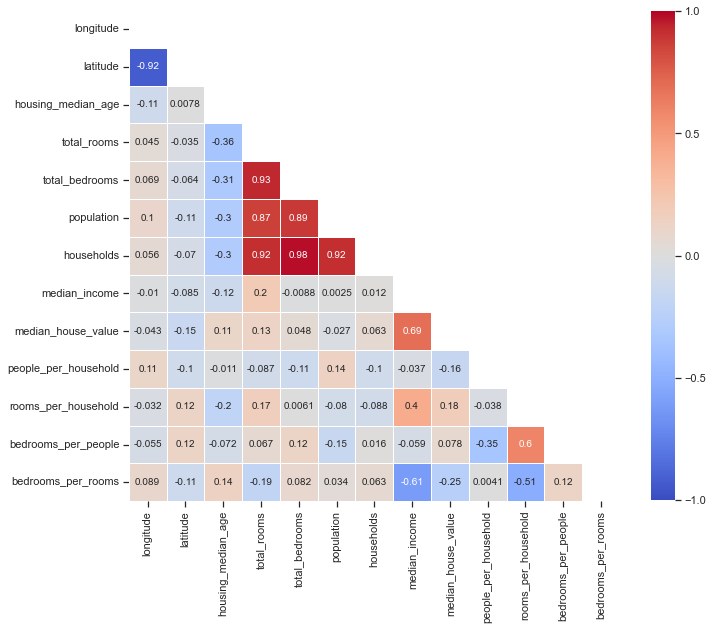

In [231]:
# Make a pretty heatmap

# Use a mask to plot only part of a matrix
mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)]= True

# Change size
plt.subplots(figsize=(11, 15))

# Build heatmap with additional options
heatmap = sns.heatmap(corr_matrix, 
                      mask = mask, 
                      square = True, 
                      linewidths = .5,
                      cmap = 'coolwarm',
                      cbar_kws = {'shrink': .6,
                                'ticks' : [-1, -.5, 0, 0.5, 1]},
                      vmin = -1,
                      vmax = 1,
                      annot = True,
                      annot_kws = {"size": 10})

Laut der Korrelationsmatrix einigen sich vor allem folgende Variablen: <br>
_median_income_ weist mit einem Wert von 0,69 die höchste Korrelation auf, danach folgen _bedrooms_per_rooms_ mit einer negativen Korrelation in Höhe von -0,25 und anschließend _people_per_household_ ebenfalls mit einer negativen Korrelation in Höhe von -0,16. <br>
Danach folgt _rooms_per_household_, allerdings kann diese Variable nicht in Kombination mit den beiden zuvor genannten genutzt werden, da sie sich aus _total_rooms_ und _households_ zusammensetzt. Diese Werte werden jedoch bereits in _bedrooms_per_rooms_ und _people_per_household_ verwendet, daher ist die zusätzliche Verwendung von _rooms_per_household_ nicht sinnvoll. <br>
_housing_median_age_ könnte mit einer Korrelation von 0,11 noch einen positiven Einfluss auf das Modell haben.

### Analyse der kategorialen Variable Ocean_Proximity

<AxesSubplot:xlabel='ocean_proximity', ylabel='median_house_value'>

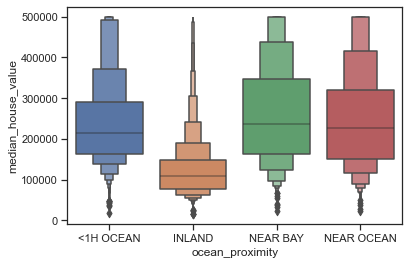

In [62]:
sns.boxenplot(data=train_dataset, x='ocean_proximity', y='median_house_value')

<AxesSubplot:xlabel='ocean_proximity', ylabel='median_house_value'>

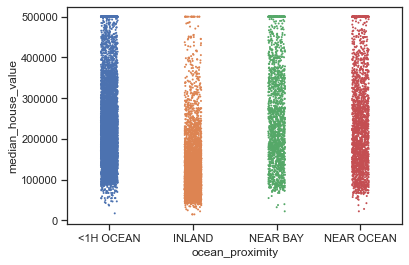

In [63]:
sns.stripplot(data=train_dataset, x='ocean_proximity', y='median_house_value', size=2)

Die Ausprägungen _NEAR BAY_ und _NEAR OCEAN_ unterscheiden sich hinsichtlich _median_house_value_ kaum. Daher können diese beiden Ausprägungen zusammengefasst werden.

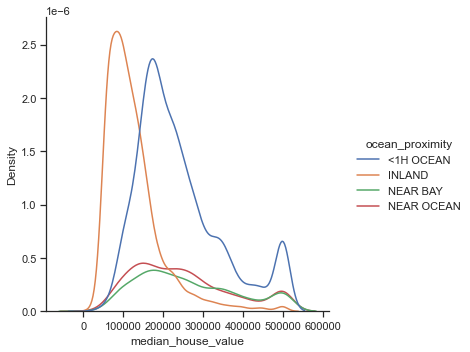

In [64]:
sns.displot(data=train_dataset, x='median_house_value', hue='ocean_proximity', kind='kde')

Auch in der Häufigkeitsverteilung zeigen _NEAR BAY_ und _NEAR OCEAN_ kaum Unterschiede. 

In [304]:
# write out a dict with the mapping of old to new
remap_cat_dict = {
    'NEAR OCEAN': 'NEAR COAST',
    'NEAR BAY': 'NEAR COAST',
    'INLAND': 'INLAND',
    '<1H OCEAN': '<1H OCEAN' }

train_dataset.ocean_proximity = train_dataset.ocean_proximity.map(remap_cat_dict).astype('category')

<AxesSubplot:xlabel='ocean_proximity', ylabel='median_house_value'>

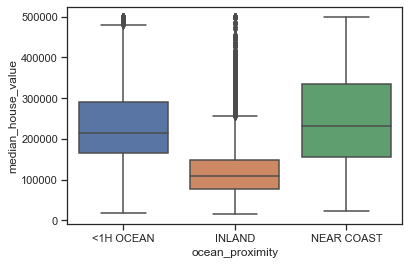

In [305]:
sns.boxplot(data=train_dataset, x='ocean_proximity', y='median_house_value')

Auch _NEAR COAST_ und _<1H OCEAN_ zeigen eine ähnliche Verteilung des Medians und der Quartile. Das 3. Quartil von _NEAR COAST_ zieht sich jedoch noch um ca. 50000$ weiter nach oben, als das von _<1H OCEAN_, daher bleibt die Differenzierung dieser beiden Ausprägungen noch bestehen. <br>
Bei der Ausprägung INLAND sind viele Ausreiser nach oben zu erkennen.

### Analyse numerischer Variablen

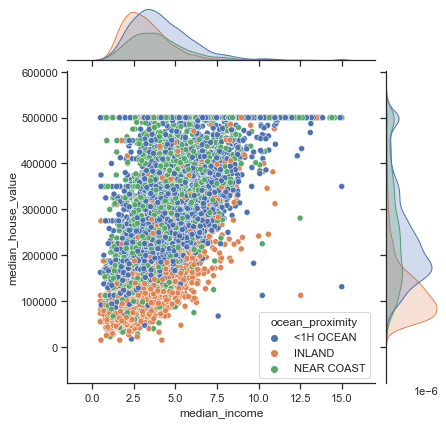

In [68]:
# check relationship with a joint plot
sns.jointplot(x="median_income", y="median_house_value", hue="ocean_proximity", data=train_dataset);

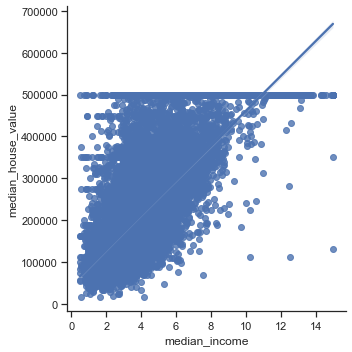

In [13]:
# check relationship with a joint plot
sns.lmplot(x="median_income", y="median_house_value", data=train_dataset);

Wie bereits aus der Korrelationsmatrix zu schließen, ist ein linearer Zusammenhang zwischen _median_income_ und _median_house_value_ erkennbar. Die "Linie" mit Datenpunkten bei 500000$ ergibt sich aus der anzunehmenden Begrenzung der median_house_value_ auf 500000$. <br>
Auch innerhalb der einzelenden Ausprägungen von _ocean_proximity_ ist eine lineare Korrelation von _median_income_ und _median_house_value_ erkennbar.

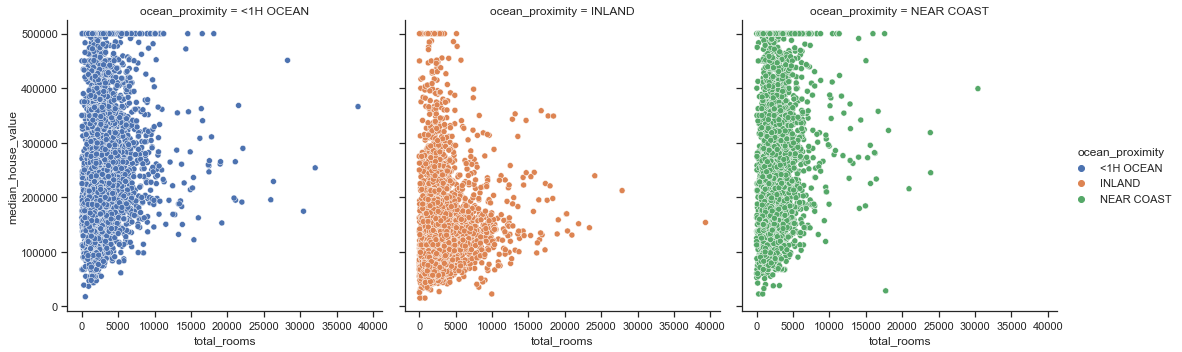

In [18]:
sns.relplot(data=train_dataset, x='total_rooms', y='median_house_value', hue='ocean_proximity', col='ocean_proximity')

Ein linearer Zusammenhang von _total_rooms_ zu _median_house_value_ ist nicht wirklich zu erkennen. Die Variable ist daher für eine lineare Regression eher ungeeignet.

In [21]:
# Plot with Plotly Express
px.scatter(x=train_dataset['bedrooms_per_rooms'], y=train_dataset['median_house_value'], opacity=0.65, 
                trendline='ols', trendline_color_override='darkred')

In [222]:
px.scatter(x=train_dataset['people_per_household'], y=train_dataset['median_house_value'], opacity=0.65, 
                trendline='ols', trendline_color_override='darkred')

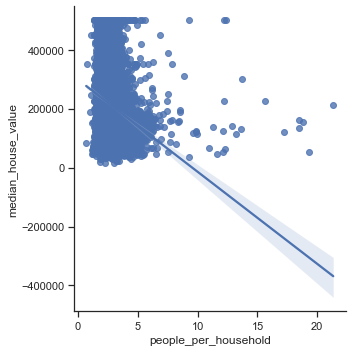

In [224]:
sns.lmplot(data=train_dataset, x='people_per_household', y='median_house_value')

_bedrooms_per_rooms_ und _people_per_household_ zeigen einen negativen linearen Zusammenhang. Dies ists gut an der Linie im Plot verdeutlicht erkennbar. Bereits in der Korrelationsmatrix war der negative Zusammenhang dieser beiden Variablen zu _median_house_value_ sichtbar. Die Variablen werden nachfolgend in die linearen Regressionsmodelle aufgenommen.

## Modellierung

### Statsmodel

#### Model 1 - OLS Regression

Als erstes Modell wird statsmodels OLS Regression verwendet. <br>
Die sogenannten Filter Methode ist eine von drei Möglichkeiten bei der Feature Selektion. Gemäß dieser werden beispielsweise auf Basis einer Korrelationsmatrix die besten Feature ausgewählt und diese dem Modell zur Verfügung gestelltn. <br>
Folgende Features wurden als geeignet identifiziert: _median_income_, _ocean_proximity_, _bedrooms_per_rooms_, _people_per_household_ und eventuell _housing_median_age_. <br>
Im ersten Modell werden die vier zuerst genannten Features verwendet.

In [306]:
# Fit Model
lm = smf.ols(formula='median_house_value ~ median_income + ocean_proximity + bedrooms_per_rooms + people_per_household' , data=train_dataset).fit()
# Full summary
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     median_house_value   R-squared:                       0.619
Model:                            OLS   Adj. R-squared:                  0.619
Method:                 Least Squares   F-statistic:                     5312.
Date:                Tue, 18 Jan 2022   Prob (F-statistic):               0.00
Time:                        01:03:32   Log-Likelihood:            -2.0580e+05
No. Observations:               16340   AIC:                         4.116e+05
Df Residuals:                   16334   BIC:                         4.116e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                      2.285e+04   4519.014      5.056      0.000     1.4e+04    3.17e+04
ocean_proximity[T.INLAND]     -6.729e+04   1415.385    -47.545      0.000   -7.01e+04   -6.45e+04
ocean_proximity[T.NEAR COAST]  1.676e+04   1428.672     11.729      0.000     1.4e+04    1.96e+04
median_income                  4.338e+04    406.094    106.829      0.000    4.26e+04    4.42e+04
bedrooms_per_rooms             3.031e+05    1.3e+04     23.248      0.000    2.78e+05    3.29e+05
people_per_household          -1.049e+04    435.520    -24.097      0.000   -1.13e+04   -9640.930
==============================================================================
Omnibus:                     4763.697   Durbin-Watson:                   1.971
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            22109.483
Skew:                           1.349   Prob(JB):                         0.00
Kurtosis:                       8.019   Cond. No.                         129.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [307]:
lm.params

Intercept                         22847.458850
ocean_proximity[T.INLAND]        -67294.434300
ocean_proximity[T.NEAR COAST]     16757.013965
median_income                     43382.483758
bedrooms_per_rooms               303138.303742
people_per_household             -10494.596699
dtype: float64

Die summary() Methode berechnet die wichtigsten Kennzahlen des Modells. <br>
R-squared ist eine Kennzahl zur Beurteilung der Anpassungsgüte eines Modells und nimmt einen Wert zwischen 0% und 100% an. Als Bezugsbasis wird der Durchschnitt verwendet. <br>
lm erreicht einen R-squared Wert in Höhe von 63,2%. Somit können 63,2% der _median_house_value_ Streuung <br>
In statistischen Methoden wird meist lieber der adjusted R-squared genutzt. Da dieser die degrees of freedom miteinbezieht, lässt sich durch adj. R-squared einen besseren Rückschluss auf die Gesamtpopulation der Datensätze ziehen. Dieser ist meistens etwas schlechter als R-squared. In diesem Modell sind beide Werte gleich hoch. <br>
Mithilfe der Kennzahlen AIC und BIC soll ein overfitting des Modells verhindert werden. Für jedes zusätzliche Feature wird eine "Bestrafung" in die Kennzahlen miteinberechnet. Je kleiner die Werte, desto besser. In diesem Modell sind die Werte jedoch relativ hoch.<br>
F-statistics ist die Menge der systematischen Varianz (MSM) geteilt durch die Menge der unsystematischen Varianz (MSR). Die Kennzahl gibt an, in welcher Höhe das Modell die Ergebnisausgabe der abhängigen Variable verbessert hat, verglichen zu Ungenauigkeit im Modell. Je höher F-statistics, desto besser. Ein F-statistics Wert in Höhe von 5618, wie in Modell lm, ist schon sehr gut. <br>
Der Y-Achsenschnittpunkt des Modells liegt bei 61394,65. Die Steigung der einzelnen Features ist in der Spalte _coef_ abzulesen. Zu interpretieren sind diese folgendermaßen: Vergrößert sich der Wert in Variable _median_income_ um 1 und alle anderen Werte bleiben konstant, so ist das Ergebnis um 42189,93 größer als zuvor. <br>
Die p-values der Features liegen alle bei 0,00. Die Nullhypothese (ß=0 => Feature hat keinen Einfluss auf die abhängige Variable) kann demnach für alle Features verworfen werden. <br>
Die p-values für Jarque-Bera und Omnibus liegen ebenfalls bei 0,00. Die Nullhypothese, die Fehler seien normalverteilt, wird in diesem Falle verworfen. Es wird also angenommen, die Residuals seien nicht normalverteilt. Bei einer Datensetgröße > 50, kann dies aufgrund des Central Limit Theorems jedoch vernachlässigt werden. <br>
Der Durbin-Watson Wert liegt bei knapp 2. Somit kann angenommen werden, dass die Fehler des Modells keine Korrelation aufweisen.


##### Regression Diagnostics

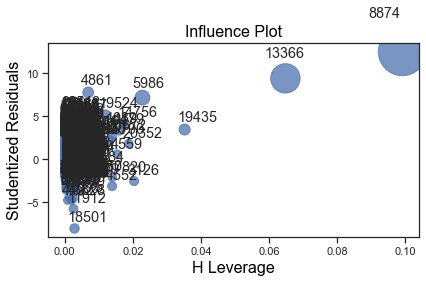

In [16]:
fig = sm.graphics.influence_plot(lm, criterion="cooks")
fig.tight_layout(pad=1.0)

Mithilfe des Influence Plots werden mögliche Ausreiser als blaue Punkte in der Größe entsprechend ihres Einflusses identifiziert. Dies können Werte mit hoher Abweichung in ihrem Y-Wert (outliers) oder X-Wert (high leverage) sein. In einer linearen Regression können solche Ausreise einen großen Einfluss auf das Gesamtmodell haben und somit die Performance des gesamten Modells erheblich verschlechtern. Als Faustregel werden Datenpunkte mit einer _Cooks Distance_ in Höhe von 4/n (wobei n die Anzahl der Datensätze ist) als mögliche Ausreiser identifiziert. 

In [308]:
# obtain Cook's distance 
lm_cooksd = lm.get_influence().cooks_distance[0]

# get length of df to obtain n
n = len(train_dataset["median_income"])
print('n = ', n)

# calculate critical d
critical_d = 4/n
print('Critical Cooks distance:', critical_d)

# identification of potential outliers with leverage
out_d = lm_cooksd > critical_d

# output potential outliers with leverage
print(train_dataset.index[out_d], "\n", 
    lm_cooksd[out_d])

n =  16340
Critical Cooks distance: 0.0002447980416156671
Int64Index([15778,  6776, 11511,  7263, 15723, 14756, 15687,  4638, 14806,
            15815,
            ...
            15809,  8866,   199, 18498,    59, 10749,  8857, 13154,  5470,
            16642],
           dtype='int64', length=921) 
 [1.48759293e-03 2.66836227e-04 4.78884475e-04 5.45180812e-04
 5.82637029e-04 5.55166261e-03 5.93629188e-04 9.64446395e-04
 7.14112179e-04 8.23043391e-04 1.37179384e-03 9.31198962e-04
 5.28353433e-04 3.14064566e-04 3.70703445e-04 7.92176597e-04
 5.76686718e-04 2.53437155e-04 5.35087643e-04 4.34543876e-04
 2.56743264e-04 4.37260421e-04 3.15946778e-04 3.85848620e-04
 2.78654618e-04 9.85584673e-04 4.69834930e-02 5.19188525e-04
 4.33272705e-04 2.46198971e-04 3.62984273e-04 3.72530337e-04
 2.66246300e-04 8.19396201e-04 4.87217083e-04 1.63877589e-03
 2.18039096e-03 1.10631997e-03 5.10220751e-04 2.98320853e-04
 4.98424061e-04 2.83831187e-03 4.23210697e-04 4.84462529e-04
 8.35832817e-04 2.56077726

In diesem Modell werden 963 Datensätze mit einer Cooks Distance > 4/n als mögliche Ausreiser identifiziert. Beispielsweise könnte versucht werden, den Einfluss dieser Datensätze auf das Modell durch Datentransformation (bspw. durch Verwendung des Logarithmus) zu verringern. Allerdings hilft diese Methode der Modellperformance genau so oft, wie sie ihr schadet. Daher wird hier auf eine Datentransformation verzichtet und die Datenpunkte stattdessen aus dem Trainings Set entfernt. 

In [309]:
#drop outliers identified by Cook's distance
train_dataset2 = train_dataset.drop(train_dataset.index[out_d])
train_dataset2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15419 entries, 14185 to 17879
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   longitude             15419 non-null  float64 
 1   latitude              15419 non-null  float64 
 2   housing_median_age    15419 non-null  int64   
 3   total_rooms           15419 non-null  int64   
 4   total_bedrooms        15419 non-null  int64   
 5   population            15419 non-null  int64   
 6   households            15419 non-null  int64   
 7   median_income         15419 non-null  float64 
 8   median_house_value    15419 non-null  float64 
 9   ocean_proximity       15419 non-null  category
 10  people_per_household  15419 non-null  float64 
 11  rooms_per_household   15419 non-null  float64 
 12  bedrooms_per_people   15419 non-null  float64 
 13  bedrooms_per_rooms    15419 non-null  float64 
dtypes: category(1), float64(8), int64(5)
memory usage:

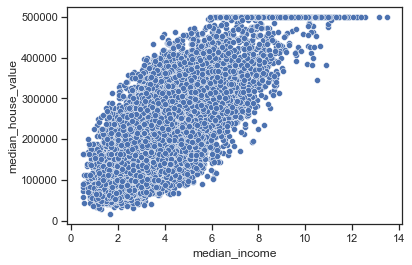

In [310]:
fig = sns.scatterplot(data=train_dataset2, x='median_income', y='median_house_value')

Im Vergleich zum ursprünglichen Trainings Set, welches im Kapitel EDA ausführlich analysiert wurde, wurden einige X- und Y-Ausreiser entfernt. Dadurch hat sich die waagrechte Punktelinie bei 500000$ _medin_house_value_ verkleinert und Ausreiser mit hohen X- und niedrigen Y-Werten wurden entfernt.

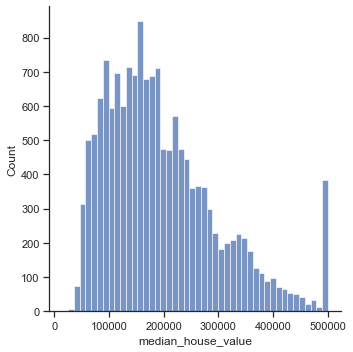

In [311]:
fig = sns.displot(data=train_dataset2, x='median_house_value')

Durch die Entfernung der Ausreiser hat sich das Histogramm von _median_house_value_ etwas weiter normalisiert.

In [312]:
# Fit Model without outliers
lm = smf.ols(formula='median_house_value ~ median_income + ocean_proximity + bedrooms_per_rooms + people_per_household', data=train_dataset2).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     median_house_value   R-squared:                       0.739
Model:                            OLS   Adj. R-squared:                  0.739
Method:                 Least Squares   F-statistic:                     8725.
Date:                Tue, 18 Jan 2022   Prob (F-statistic):               0.00
Time:                        01:04:55   Log-Likelihood:            -1.8952e+05
No. Observations:               15419   AIC:                         3.790e+05
Df Residuals:                   15413   BIC:                         3.791e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                      3.341e+04   4404.814      7.585      0.000    2.48e+04     4.2e+04
ocean_proximity[T.INLAND]       -6.1e+04   1098.946    -55.509      0.000   -6.32e+04   -5.88e+04
ocean_proximity[T.NEAR COAST]  6838.7281   1120.708      6.102      0.000    4642.008    9035.448
median_income                  4.689e+04    365.489    128.285      0.000    4.62e+04    4.76e+04
bedrooms_per_rooms              3.58e+05   1.21e+04     29.558      0.000    3.34e+05    3.82e+05
people_per_household          -2.492e+04    583.778    -42.686      0.000   -2.61e+04   -2.38e+04
==============================================================================
Omnibus:                      958.072   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1206.262
Skew:                           0.599   Prob(JB):                    1.16e-262
Kurtosis:                       3.664   Cond. No.                         154.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Durch die Entfernung der Ausreiser haben sich R-squared, adjusted R-squared und F-statistics deutlich verbessert. <br>
AIC und BIC sind auch etwas kleiner geworden und haben sich somit verbessert. <br>
Die p-values der Features bleiben unverändert. <br>
Auch an den p-values für Jarque-Bera und Omnibus hat sich kaum etwas verändert. <br>
Durbin-Watson liegt nun bei einem Wert <> 2. Generell ist bei einem Wert von > 2 eine negative Korrelation der Modellfehler anzunehmen. 

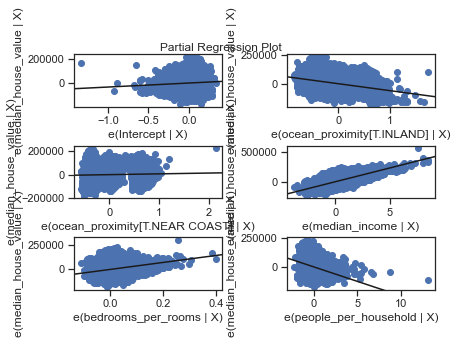

In [196]:
fig = sm.graphics.plot_partregress_grid(lm)
fig.tight_layout(pad=0.2)

Die Partial Regression Plots visualisieren die Relation einer unabhängigen Variablen in Verbindung mit den anderen abhängigen Variablen im Modell in Bezug auf die abhängige Variable. <br>
Die Plots zeigen eine negative Abhängigkeit von der Ausprägung _I.INLAND_ von _ocean_proximity_ und _peope_per_household_. _Median_income_ und _bedrooms_per_rooms_ scheinen eine positive Abhängigkeit auf _median_house_value_ zu haben. Gemäß dem Diagramm hat die Variable _ocean_proximity[T.NEAR COAST]_ keinen Einfluss auf _median_income_. Dies steht im Gegensatz zum p-value 0,00 dieser Variablen, nach dessen Interpretation die Variable einen Einfluss auf die abhängige Variable hat.

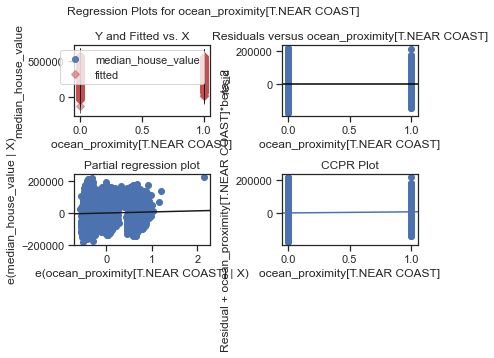

In [197]:
fig = sm.graphics.plot_regress_exog(lm, "ocean_proximity[T.NEAR COAST]")
fig.tight_layout(pad=1.0)

Auch diese Plots lassen darauf schließen, dass die Variable _ocean_proximity[T.NEAR COAST] das Modell nicht verbessert. Sowohl Partial Regression Plot als auch CCPR Plot visualisieren eine Nicht-Linearität zwischen der Variablen und _median_house_value_. <br>
Die Residuals scheinen dagegen gleichmäßig verteilt zu sein.

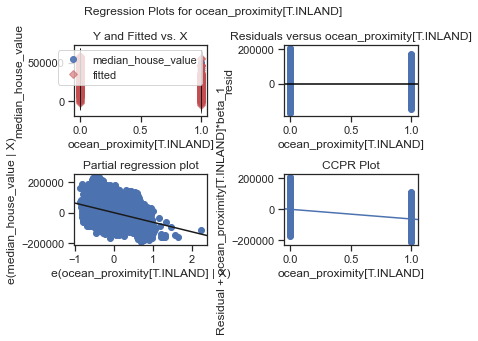

In [27]:
fig = sm.graphics.plot_regress_exog(lm, "ocean_proximity[T.INLAND]")
fig.tight_layout(pad=1.0)

Die negative Korrelation ist sowohl im Partial Regression Plot als auch im CCPR Plot zu erkennen. Die Residuals sind gleichmäßig verteilt und lassen daher auf Homoskedastizität rückschließen. Das Diagramm zu Y and Fitted vs. X ist aufgrund der vielen Datenpunkte schwer zu analysieren.

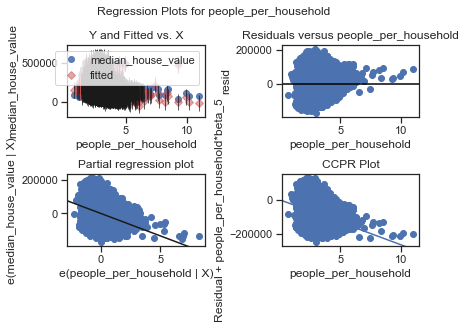

In [45]:
fig = sm.graphics.plot_regress_exog(lm, "people_per_household")
fig.tight_layout(pad=1.0)

Auch hier ist eine negative Abhängigkeit der abhängigen zur unabhängigen Variablen zu erkennen. Linearität scheint also vorzuliegen. Allerdings ist im Residual Plot keine konstante Varianz der Fehlerstreuung zu erkennen. Mit steigendem X-Wert verringert sich die Fehlerstreuung und liegt nur noch im positiven Bereich. Mit zunehmender _people_per_household_ wird tendenziell ein höherer _median_house_value_ mit dem Modell hervorgesagt, als tatsächlich vorliegt. Dies spiegelt sich auch im Plot zu Y and Fitted vs. X wieder. Bei dieser Variablen liegt somit Heteroskedastizität vor. Die Ursache hierfür könnte darin liegen, dass im höheren Wertebereich von _people_per_household_ deutlich weniger Datensätze vorliegen als im niedrigeren Bereich und das Modell somit nicht ausreichend für diese Wertebereiche trainiert wurde. Womöglich bildet auch eine polynomiale Modellierung für diese Variable die Relation der Variablen besser ab.

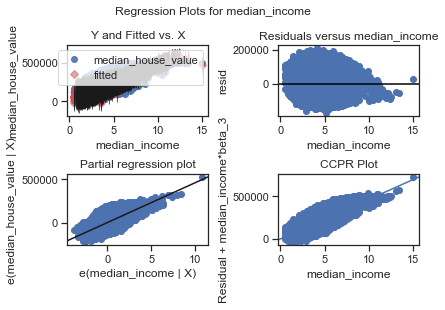

In [46]:
fig = sm.graphics.plot_regress_exog(lm, "median_income")
fig.tight_layout(pad=1.0)

Für _median_income_ ist die Linearität im Partial Regression Plot und CCPR Plot deutlich zu erkennen. Jedoch nimmt auch hier die Streuung der Residuals im höheren X-Wertebereich ab. 

In [313]:
# write out a dict with the mapping of old to new
remap_cat_dict = {
    'NEAR COAST': 'NEAR COAST',
    'INLAND': 'INLAND',
    '<1H OCEAN': 'NEAR COAST' }

train_dataset.ocean_proximity = train_dataset.ocean_proximity.map(remap_cat_dict).astype('category')

#### Model 2 - OLS Regression


Nachfolgend wird ein weiteres Modell mit zusätzlicher Verwendung der Variablen _housing_median_age_ trainiert.

In [319]:
# Fit Model
lm2 = smf.ols(formula='median_house_value ~ median_income + ocean_proximity + bedrooms_per_rooms + people_per_household + housing_median_age', data=train_dataset).fit()
lm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     median_house_value   R-squared:                       0.627
Model:                            OLS   Adj. R-squared:                  0.627
Method:                 Least Squares   F-statistic:                     5486.
Date:                Tue, 18 Jan 2022   Prob (F-statistic):               0.00
Time:                        01:08:50   Log-Likelihood:            -2.0563e+05
No. Observations:               16340   AIC:                         4.113e+05
Df Residuals:                   16334   BIC:                         4.113e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                     -7.016e+04   4213.120    -16.652      0.000   -7.84e+04   -6.19e+04
ocean_proximity[T.NEAR COAST]  6.563e+04   1348.977     48.655      0.000     6.3e+04    6.83e+04
median_income                  4.445e+04    406.063    109.460      0.000    4.37e+04    4.52e+04
bedrooms_per_rooms             2.998e+05   1.29e+04     23.243      0.000    2.74e+05    3.25e+05
people_per_household          -1.096e+04    428.532    -25.570      0.000   -1.18e+04   -1.01e+04
housing_median_age             1005.0830     46.230     21.741      0.000     914.467    1095.699
==============================================================================
Omnibus:                     4984.528   Durbin-Watson:                   1.968
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            27788.201
Skew:                           1.356   Prob(JB):                         0.00
Kurtosis:                       8.785   Cond. No.                         766.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

R-squared und adj. R-squared haben sich im Vergleich zum ersten Modell verbessert. <br>
Auch F-statistics hat sich durch die Entfernung der Ausprägung von _ocean_proximity_ und Aufnahme des Features _median_housing_age_ verbessert. <br>
Alle übrigen Kennzahlen haben sich kaum verändert.

In [320]:
# obtain Cook's distance 
lm_cooksd = lm2.get_influence().cooks_distance[0]

# get length of df to obtain n
n = len(train_dataset["median_income"])
print('n = ', n)

# calculate critical d
critical_d = 4/n
print('Critical Cooks distance:', critical_d)

# identification of potential outliers with leverage
out_d = lm_cooksd > critical_d

# output potential outliers with leverage
print(train_dataset.index[out_d], "\n", 
    lm_cooksd[out_d])

n =  16340
Critical Cooks distance: 0.0002447980416156671
Int64Index([15778,  6776, 10005, 11511,  7263, 15723, 14756, 15687,  4638,
            14806,
            ...
            15809,  8866,   199, 18498,    59, 10749,  8857, 13154,  5470,
            16642],
           dtype='int64', length=834) 
 [1.34620956e-03 3.28749861e-04 2.57215207e-04 3.35039575e-04
 6.51518260e-04 3.61919469e-04 7.91550903e-03 6.11015995e-04
 6.49112668e-04 4.17870132e-04 8.15554753e-04 1.30731202e-03
 1.20416904e-03 3.73036827e-04 5.62180943e-04 7.70163204e-04
 5.46624084e-04 2.53753610e-04 3.01304709e-04 5.38305099e-04
 3.35811574e-04 2.54781398e-04 4.29838436e-04 3.35159404e-04
 3.69843859e-04 3.46408581e-04 2.57119718e-04 5.47776435e-02
 4.46822263e-04 4.27225287e-04 3.34569001e-04 8.73800145e-04
 5.12264946e-04 1.65774076e-03 2.06412271e-03 1.04840879e-03
 2.72011719e-04 5.81620070e-04 5.20076218e-04 5.13152695e-03
 5.17172666e-04 9.28482089e-04 4.71110244e-03 3.95928870e-04
 2.95769203e-04 2.62218028

Auch in Modell lm2 werden mögliche outliers und Punkte mit high leverage identifiziert und aus dem Datenset entfernt.

In [321]:
#drop outliers identified by Cook's distance
train_dataset2 = train_dataset.drop(train_dataset.index[out_d])
train_dataset2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15506 entries, 14185 to 17879
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   longitude             15506 non-null  float64 
 1   latitude              15506 non-null  float64 
 2   housing_median_age    15506 non-null  int64   
 3   total_rooms           15506 non-null  int64   
 4   total_bedrooms        15506 non-null  int64   
 5   population            15506 non-null  int64   
 6   households            15506 non-null  int64   
 7   median_income         15506 non-null  float64 
 8   median_house_value    15506 non-null  float64 
 9   ocean_proximity       15506 non-null  category
 10  people_per_household  15506 non-null  float64 
 11  rooms_per_household   15506 non-null  float64 
 12  bedrooms_per_people   15506 non-null  float64 
 13  bedrooms_per_rooms    15506 non-null  float64 
dtypes: category(1), float64(8), int64(5)
memory usage:

In [322]:
# Fit Model
lm2 = smf.ols(formula='median_house_value ~ median_income + ocean_proximity + bedrooms_per_rooms + people_per_household + housing_median_age', data=train_dataset2).fit()
lm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     median_house_value   R-squared:                       0.743
Model:                            OLS   Adj. R-squared:                  0.743
Method:                 Least Squares   F-statistic:                     8956.
Date:                Tue, 18 Jan 2022   Prob (F-statistic):               0.00
Time:                        01:09:17   Log-Likelihood:            -1.9073e+05
No. Observations:               15506   AIC:                         3.815e+05
Df Residuals:                   15500   BIC:                         3.815e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                     -5.584e+04   4076.067    -13.700      0.000   -6.38e+04   -4.79e+04
ocean_proximity[T.NEAR COAST]  5.731e+04   1067.209     53.703      0.000    5.52e+04    5.94e+04
median_income                   4.88e+04    370.848    131.580      0.000    4.81e+04    4.95e+04
bedrooms_per_rooms              3.69e+05   1.19e+04     30.882      0.000    3.46e+05    3.92e+05
people_per_household          -2.592e+04    562.240    -46.097      0.000    -2.7e+04   -2.48e+04
housing_median_age              924.7246     36.788     25.137      0.000     852.616     996.833
==============================================================================
Omnibus:                     1156.804   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1572.169
Skew:                           0.645   Prob(JB):                         0.00
Kurtosis:                       3.876   Cond. No.                         911.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Die Modellperformance liegt nun bei 74,3% und ist somit bisher der beste erzielte Wert der Kennzahl R-squared. <br>
F-statistics hat sich ebenfalls verbessert, auch im Vergleich zu Model 1. <br>
Alle anderen Werte liegen in einem ähnlichen Wertebereich.

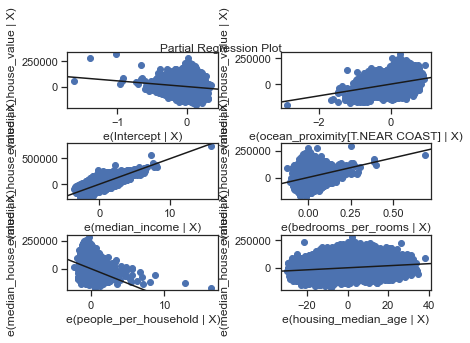

In [203]:
fig = sm.graphics.plot_partregress_grid(lm2)
fig.tight_layout(pad=0.2)

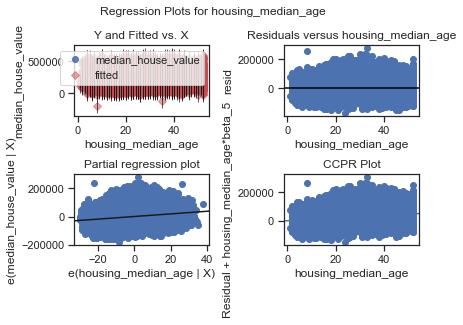

In [323]:
fig = sm.graphics.plot_regress_exog(lm2, "housing_median_age")
fig.tight_layout(pad=1.0)

Das Partial Regression Plot und CCPR Plot zeigen eine geringe lineare Korrelation von _housing_median_age_ in Verbindung mit den anderen unabhängigen Variablen auf _median_house_value_. <br>
Das Residual Plot zeigt eine deutliche Homoskedastizität.

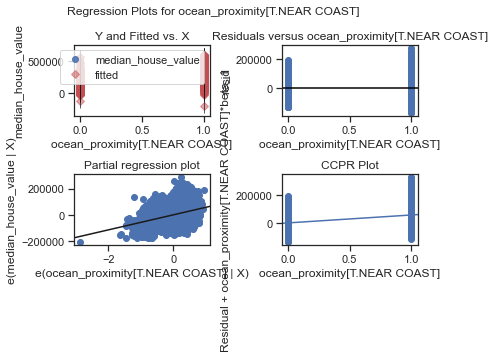

In [324]:
fig = sm.graphics.plot_regress_exog(lm2, "ocean_proximity[T.NEAR COAST]")
fig.tight_layout(pad=1.0)

Die Plots von _ocean_proximity[T.NEAR COAST]_ zeigen keine große Veränderung zu Modell lm.

In der linearen Regression muss eine Colinearität der unabhängigen Variablen unbedingt vermieden werden. Mithilfe des Variance Inflation Factors (VIF) kann der Grad der Colinearität der im Modell verwendeten Variablen berechnet werden. Der kleinstmögliche Wert ist 1. Problematisch wird es ab Werten > 5.

In [325]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# choose features and add constant
features = add_constant(train_dataset2[['median_income', 'bedrooms_per_rooms', 'people_per_household', 'housing_median_age']])
# create empty DataFrame
vif = pd.DataFrame()
# calculate vif
vif["VIF Factor"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]
# add feature names
vif["Feature"] = features.columns

vif.round(2)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



VIF Factor               Feature
0       82.06                 const
1        1.80         median_income
2        1.79    bedrooms_per_rooms
3        1.01  people_per_household
4        1.03    housing_median_age

Der Wert der Konstanten kann ignoriert werden. Ansonsten ist die Colinearität der Variablen eher gering.

Die Modelle lm und lm2 sind sehr ähnlich. R-squared ist bei lm2 ca. 1% besser, dafür hat sich der Wert von F-statistics von lm zu lm2 um ca. 1000 verschlechtert. AIC und BIC haben sich nicht wesentlich verändert. Die Werte sind von lm zu lm2 sogar geringfügig kleiner (also besser) geworden, obwohl für zusätzliche Features ein Penalty Term einberechnet wird, um overfitting zu vermeiden. Das Partial Regression Plot der Variablen _median_housing_age_ zeigt zwar nur eine geringe Linearität, dennoch scheint die Aufnahme der Variablen das Modell etwas zu verbessern.

#### Model 2 - Lasso Regression

Nachfolgend wird eine Lasso Regression mit statsmodels fit_regularized() Methode trainiert. Der Wert von alpha wird auf 5 gesetzt.

In [242]:
lasso1 = smf.ols(formula='median_house_value ~ median_income + ocean_proximity + bedrooms_per_rooms + people_per_household + housing_median_age', data=train_dataset2).fit_regularized(method='sqrt_lasso', alpha=5.0, L1_wt=1.0, max_iter=1000)

In [326]:
print("Parameters: ", lasso1.params)

Parameters:  Intercept                        -50616.495719
ocean_proximity[T.NEAR COAST]     57809.976303
median_income                     48394.058880
bedrooms_per_rooms               351976.704469
people_per_household             -26004.829908
housing_median_age                  918.971072
dtype: float64


Da die Summary() Methode für statsmodels fit_regularized() Medelle nicht verfügbar ist, müssen wichtige Kennzahlen selbst berechnet werden.

In [245]:
# calculate the mean 
train_dataset2['average'] = train_dataset2["median_house_value"].mean()

# calculate error (observation - average) and assign it to dataframe
train_dataset2 = train_dataset2.assign(error = (train_dataset2['median_house_value'] - train_dataset2['average']))

# calculate squared error and assign it to dataframe
train_dataset2 = train_dataset2.assign(error_sq = (train_dataset2['median_house_value'] - train_dataset2['average'])**2)


# obtain predicted value from model lasso
train_dataset2['pred'] = lasso1.predict()

# obtain the residuals from statsmodel (resid)
train_dataset2['error_2'] = train_dataset2['median_house_value'] - train_dataset2['pred']

# square the residuals 
train_dataset2['error_sq_2'] = train_dataset2['error_2']**2

# show df
train_dataset2.head(5)

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
14185    -117.08     32.70                  37         2176             418   
6125     -117.91     34.11                  20         3158             684   
14095    -117.10     32.75                  11         2393             726   
14359    -117.22     32.74                  52         1260             202   
18004    -121.99     37.29                  32         2930             481   

       population  households  median_income  median_house_value  \
14185        1301         375         2.8750             98900.0   
6125         2396         713         3.5250            153000.0   
14095        1905         711         1.3448             91300.0   
14359         555         209         7.2758            345200.0   
18004        1336         481         6.4631            344100.0   

      ocean_proximity  people_per_household  rooms_per_household  \
14185      NEAR COAST              3.469333             5.802667   
6125       NEAR COAST              3.360449             4.429173   
14095      NEAR COAST              2.679325             3.365682   
14359      NEAR COAST              2.655502             6.028708   
18004      NEAR COAST              2.777547             6.091476   

       bedrooms_per_people  bedrooms_per_rooms        average          error  \
14185             0.321291            0.192096  196674.726944  -97774.726944   
6125              0.285476            0.216593  196674.726944  -43674.726944   
14095             0.381102            0.303385  196674.726944 -105374.726944   
14359             0.363964            0.160317  196674.726944  148525.273056   
18004             0.360030            0.164164  196674.726944  147425.273056   

           error_sq           pred       error_2    error_sq_2  
14185  9.559897e+09  157722.078408 -58822.078408  3.460037e+09  
6125   1.907482e+09  185009.672924 -32009.672924  1.024619e+09  
14095  1.110383e+10  119491.512237 -28191.512237  7.947614e+08  
14359  2.205976e+10  394457.593271 -49257.593271  2.426310e+09  
18004  2.173421e+10  334928.406586   9171.593414  8.411813e+07

In [246]:
# calculate sum of squared error (which is in case of the mean the total error)
TSS = train_dataset2.error_sq.sum()
# print output
print('Sum of squared error (TSS) of model 1:', TSS)

# Sum of squared residuals (SS_R)
SSR = train_dataset2['error_sq_2'].sum()
print('Sum of squared residuals (SSR) of model 1:',SSR)

Sum of squared error (TSS) of model 1: 170542426261911.88
Sum of squared residuals (SSR) of model 1: 43859574696952.75


In [247]:
# Explained sum of squares  (SS_M = TSS - SS_R)
SSM = TSS - SSR
print('SSM of Lasso Model: ', SSM)

# R_Squared: explained sum of squared residuals
R_squared = SSM / TSS
print('R squared Lasso Model:', R_squared)

SSM of Lasso Model:  126682851564959.12
R squared Lasso Model: 0.7428230871443388


R-squared ist durch die Regularisierung nochmal etwas besser geworden.<br>
Für einen optimalen Wert von alpha müsste eigentlich eine Cross-Validation durchgeführt werden. Darauf wird an dieser Stelle jedoch verzichtet.

#### Model 3 - Cubic Spline

Nun wird eine Cubic Spline unter Verwendung von Patsy und Statsmodels trainiert. Eine Verwendung von mehreren unabhängigen Variablen ist dabei nicht ohne Weiteres möglich. Daher wird nachfolgend lediglich die Variable mit der höchsten Korrelation zu _median_house_value_ verwendet. Dabei handelt es sich um _median_income_.

In [248]:
X_train = train_dataset2['median_income']
y_train = train_dataset2['median_house_value']
X_test = test_dataset['median_income']
y_test = test_dataset['median_house_value']


In [249]:
from patsy import dmatrix

# Generating cubic spline with 3 knots at 25, 40 and 60
transformed_x = dmatrix(
            "bs(train, knots=(3,6,9), degree=3, include_intercept=False)", 
                {"train": X_train},return_type='dataframe')

In [250]:
# Fitting generalised linear model on transformed dataset
spline1 = sm.GLM(y_train, transformed_x).fit()

In [251]:
spline1.predict()
spline1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:     median_house_value   No. Observations:                15506
Model:                            GLM   Df Residuals:                    15499
Model Family:                Gaussian   Df Model:                            6
Link Function:               identity   Scale:                      4.6148e+09
Method:                          IRLS   Log-Likelihood:            -1.9452e+05
Date:                Tue, 18 Jan 2022   Deviance:                   7.1525e+13
Time:                        00:43:42   Pearson chi2:                 7.15e+13
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
====================================================================================================================================
                                                                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                         1.081e+05   8237.478     13.122      0.000    9.19e+04    1.24e+05
bs(train, knots=(3, 6, 9), degree=3, include_intercept=False)[0] -3.748e+04   1.09e+04     -3.448      0.001   -5.88e+04   -1.62e+04
bs(train, knots=(3, 6, 9), degree=3, include_intercept=False)[1]  7.416e+04   7398.863     10.023      0.000    5.97e+04    8.87e+04
bs(train, knots=(3, 6, 9), degree=3, include_intercept=False)[2]  1.575e+05   9980.819     15.782      0.000    1.38e+05    1.77e+05
bs(train, knots=(3, 6, 9), degree=3, include_intercept=False)[3]   4.47e+05   1.06e+04     41.988      0.000    4.26e+05    4.68e+05
bs(train, knots=(3, 6, 9), degree=3, include_intercept=False)[4]  3.524e+05   1.97e+04     17.854      0.000    3.14e+05    3.91e+05
bs(train, knots=(3, 6, 9), degree=3, include_intercept=False)[5]  4.232e+05   4.12e+04     10.269      0.000    3.42e+05    5.04e+05
====================================================================================================================================
"""

In [252]:
# obtain predicted value from model spline
train_dataset2['pred_spline'] = spline1.predict()

# obtain the residuals from statsmodel (resid)
train_dataset2['error_2_spline'] = train_dataset2['median_house_value'] - train_dataset2['pred_spline']

# square the residuals 
train_dataset2['error_sq_2_spline'] = train_dataset2['error_2_spline']**2

# show df
train_dataset2.head(5)

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
14185    -117.08     32.70                  37         2176             418   
6125     -117.91     34.11                  20         3158             684   
14095    -117.10     32.75                  11         2393             726   
14359    -117.22     32.74                  52         1260             202   
18004    -121.99     37.29                  32         2930             481   

       population  households  median_income  median_house_value  \
14185        1301         375         2.8750             98900.0   
6125         2396         713         3.5250            153000.0   
14095        1905         711         1.3448             91300.0   
14359         555         209         7.2758            345200.0   
18004        1336         481         6.4631            344100.0   

      ocean_proximity  ...  bedrooms_per_rooms        average          error  \
14185      NEAR COAST  ...            0.192096  196674.726944  -97774.726944   
6125       NEAR COAST  ...            0.216593  196674.726944  -43674.726944   
14095      NEAR COAST  ...            0.303385  196674.726944 -105374.726944   
14359      NEAR COAST  ...            0.160317  196674.726944  148525.273056   
18004      NEAR COAST  ...            0.164164  196674.726944  147425.273056   

           error_sq           pred       error_2    error_sq_2    pred_spline  \
14185  9.559897e+09  157722.078408 -58822.078408  3.460037e+09  154283.626628   
6125   1.907482e+09  185009.672924 -32009.672924  1.024619e+09  183299.913013   
14095  1.110383e+10  119491.512237 -28191.512237  7.947614e+08   96456.816818   
14359  2.205976e+10  394457.593271 -49257.593271  2.426310e+09  372578.112664   
18004  2.173421e+10  334928.406586   9171.593414  8.411813e+07  319906.620313   

       error_2_spline  error_sq_2_spline  
14185   -55383.626628       3.067346e+09  
6125    -30299.913013       9.180847e+08  
14095    -5156.816818       2.659276e+07  
14359   -27378.112664       7.495611e+08  
18004    24193.379687       5.853196e+08  

[5 rows x 23 columns]

In [253]:
# Sum of squared residuals (SSR)
SSR_spline = train_dataset2['error_sq_2_spline'].sum()
print('Sum of squared residuals (SSR) of Cubic Spline:',SSR_spline)

# Explained sum of squares  (SS_M = TSS - SS_R)
SSM_spline = TSS - SSR_spline
print('SSM of Cubic Spline: ', SSM_spline)

# R_Squared: explained sum of squared residuals
R_squared_spline = SSM_spline / TSS
print('R squared of Cubic Spline:', R_squared_spline)

Sum of squared residuals (SSR) of Cubic Spline: 71524714796268.75
SSM of Cubic Spline:  99017711465643.12
R squared of Cubic Spline: 0.5806045664764725


In [255]:
print(skm.r2_score(train_dataset2['median_house_value'], train_dataset2['pred_spline']))

0.5806045664764725


R squared ist schlechter geworden als in den vorherigen Modellen. Allerdings liegt dies darin begründet, dass nur ein Feature verwendet wurde. Ein direkter Vergleich ist also nicht möglich.

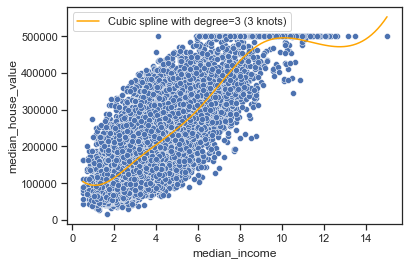

In [187]:
# Create observations
xp = np.linspace(X_test.min(),X_test.max(), 100)
# Make some predictions
pred = spline1.predict(dmatrix("bs(xp, knots=(3, 6, 9), include_intercept=False)", {"xp": xp}, return_type='dataframe'))

# plot
sns.scatterplot(x=X_train, y=y_train)

plt.plot(xp, pred, label='Cubic spline with degree=3 (3 knots)', color='orange')
plt.legend();

#### Model 4 - Natural Spline

In [204]:
transformed_x3 = dmatrix("cr(train,df = 3)", {"train": X_train}, return_type='dataframe')

spline2 = sm.GLM(y_train, transformed_x3).fit()

In [174]:
# obtain predicted value from model spline
train_dataset2['pred_spline'] = spline2.predict()

# obtain the residuals from statsmodel (resid)
train_dataset2['error_2_spline'] = train_dataset2['median_house_value'] - train_dataset2['pred_spline']

# square the residuals 
train_dataset2['error_sq_2_spline'] = train_dataset2['error_2_spline']**2

# show df
train_dataset2.head(5)

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
14185    -117.08     32.70                  37         2176             418   
6125     -117.91     34.11                  20         3158             684   
14095    -117.10     32.75                  11         2393             726   
14359    -117.22     32.74                  52         1260             202   
18004    -121.99     37.29                  32         2930             481   

       population  households  median_income  median_house_value  \
14185        1301         375         2.8750             98900.0   
6125         2396         713         3.5250            153000.0   
14095        1905         711         1.3448             91300.0   
14359         555         209         7.2758            345200.0   
18004        1336         481         6.4631            344100.0   

      ocean_proximity  ...  bedrooms_per_rooms        average          error  \
14185      NEAR COAST  ...            0.192096  195254.121813  -96354.121813   
6125        <1H OCEAN  ...            0.216593  195254.121813  -42254.121813   
14095      NEAR COAST  ...            0.303385  195254.121813 -103954.121813   
14359      NEAR COAST  ...            0.160317  195254.121813  149945.878187   
18004       <1H OCEAN  ...            0.164164  195254.121813  148845.878187   

           error_sq           pred       error_2    error_sq_2    pred_spline  \
14185  9.284117e+09  157516.967720 -58616.967720  3.435949e+09  153409.972829   
6125   1.785411e+09  182232.226163 -29232.226163  8.545230e+08  180983.759544   
14095  1.080646e+10  122387.245306 -31087.245306  9.664168e+08   90298.835046   
14359  2.248377e+10  394045.429765 -48845.429765  2.385876e+09  352306.649672   
18004  2.215510e+10  331461.374605  12638.625395  1.597349e+08  313580.198527   

       error_2_spline  error_sq_2_spline  
14185   -54509.972829       2.971337e+09  
6125    -27983.759544       7.830908e+08  
14095     1001.164954       1.002331e+06  
14359    -7106.649672       5.050447e+07  
18004    30519.801473       9.314583e+08  

[5 rows x 23 columns]

In [176]:
# Sum of squared residuals (SSR)
SSR_spline = train_dataset2['error_sq_2_spline'].sum()
print('Sum of squared residuals (SSR) of Natural Spline:',SSR_spline)

# Explained sum of squares  (SS_M = TSS - SS_R)
SSM_spline = TSS - SSR_spline
print('SSM of Natural Spline: ', SSM_spline)

# R_Squared: explained sum of squared residuals
R_squared_spline = SSM_spline / TSS
print('R squared of Natural Spline:', R_squared_spline)

Sum of squared residuals (SSR) of Natural Spline: 67847658465067.86
SSM of Natural Spline:  95453782865582.95
R squared of Natural Spline: 0.5845250482040099


R-squared ist im Vergleich zur Cubic Spline nochmal gesunken. Auch hier wird im Modell nur eine unabhängige Variable verwendet.

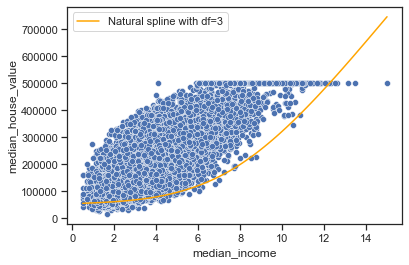

In [177]:
# Make predictions
pred = spline2.predict(dmatrix("cr(xp, df=3)", {"xp": xp}, return_type='dataframe'))

# plot
sns.scatterplot(x=X_train, y=y_train)
plt.plot(xp, pred, color='orange', label='Natural spline with df=3')
plt.legend()

### Scikit Learn

#### Data Preprocessing Pipeline

Initialisierung der Preprocessing Pipeline. Mithilfe einer Preprocessing Pipelines müssen die Daten nicht manuell transformiert werden, da diesse Aufgaben von der Pipeline übernommen werden. <br>
Für numerische Variablen gehört dazu die Normalisierung der Variablen, sowie die Belegung nicht befüllter Datensätze mit dem Durchschnittswert des Features. <br>
Bei kategorialen Variablen werden fehlnde Werte durch eine Konstante belegt und automatisiert Dummy Variablen für die verschiedenen Ausprägungen der Variablen erzeugt.

In [38]:
# for numeric features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()) #Normalisierung (X=(X-Mittelwert) / Standardabweichung)
    ])

In [39]:
# for categorical features  
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')), #Konstante bei fehlenden Werten reinschreiben
    ('onehot', OneHotEncoder(handle_unknown='ignore')) #pro Featureausprägung eine Spalte, zutreffendes Feature hat dann Wert 1 und die anderen Wert 0
    ])

In [40]:
# Pipeline
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, selector(dtype_exclude="category")),
    ('cat', categorical_transformer, selector(dtype_include="category"))
        ])

#### Datenvorbereitung

Für Scikit Learn muss die abhängige Variable von den unabhängigen getrennt werden. Als Datenbasis wird hier auf train_dataset2 zugegriffen. In diesem Datenset wurden die Outlier nach Cook's Distance bereits entfernt. Als Features sollen die durch die Filter Methode identifizierten und bereits in statsmodels verwendeten Features genutzt werden.

In [256]:
# create label y
y = train_dataset2['median_house_value']

# create features
X= train_dataset2[['median_income', 'ocean_proximity', 'bedrooms_per_rooms', 'people_per_household', 'housing_median_age']]


Scikit Learn bietet eine eigene Methode zum Datensplitting. Das Datenset train_dataset2 aus statsmodels wird nun nochmal in Test- und Trainingsdaten aufgeteilt. Dadurch ist Validierung der Modelle bereits mit diesem Testset möglich, bevor am Ende dieses Notebooks mit den bereits zu Beginn zur Seite gelegten Testdaten das beste Modell evaluiert wird.

In [257]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [258]:
print("Training size:", len(X_train))
print("Test size:", len(X_test))

Training size: 12404
Test size: 3102


#### Model 5 - Simple Regression

Nun wird ein Pipeline Object erzeugt, welches zunächst die Data Preprocessing Pipeline ausführt und anschließend das Regressionsmodell.

In [259]:
# Create pipeline with model
lm_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('lm', LinearRegression())
                        ])

# Fit model
lm_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000019AF0E691C0>),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
      

In der Variable features_names werden die Namen der Features gespeichert.

In [260]:
feature_names = np.concatenate((X_train.drop(['ocean_proximity'], axis=1).columns.to_numpy(), lm_pipe.named_steps['preprocessor'].transformers_[1][1]['onehot'].get_feature_names_out()))
feature_names

array(['median_income', 'bedrooms_per_rooms', 'people_per_household',
       'housing_median_age', 'x0_INLAND', 'x0_NEAR COAST'], dtype=object)

Der eben erzeugte feature_names Array kann nun mit den Koeffizienten des Modells ergänzt werden, um die Koeffizienten je Feature auszugeben.

In [261]:
# Obtain model coefficients and names
print('Koeffizienten und Namen: \n', list(zip(lm_pipe.named_steps['lm'].coef_, feature_names)))

Koeffizienten und Namen: 
 [(85229.2089681146, 'median_income'), (19379.143797351342, 'bedrooms_per_rooms'), (-19642.68963026445, 'people_per_household'), (11314.894820139021, 'housing_median_age'), (-28646.670935754682, 'x0_INLAND'), (28646.670935754682, 'x0_NEAR COAST')]


Das trainierte Modell wird nun für die Berechnung der _median_house_values_ der Trainingsdaten verwendet.

In [262]:
y_pred = lm_pipe.predict(X_train)
y_pred

array([186053.02255921,  51495.90700283, 263988.77300622, ...,
       152104.43702161, 122857.34230185, 120051.11769621])

In [263]:
# Metrics trainings set
print('R squared training set:', round(skm.r2_score(y_train, y_pred)*100, 2))
print('MSE training set:', round(skm.mean_squared_error(y_train, y_pred), 2))
print('RMSE training set:', round(skm.mean_squared_error(y_train, y_pred, squared=False), 2))

R squared training set: 74.18
MSE training set: 2816155847.98
RMSE training set: 53067.47


Das Modell hat einen ähnlichen R-squared wie die OLS Regression in statsmodels. Der Root Mean Squared Error des Modells beträgt 50968,88$. Das bedeutet, dass der eigentliche Wert von _median_house_value_ im Schnitt um diesen Betrag von dem durch das Modell berechneten Ergebnis abweicht. 

Im Folgenden wird das Modell mit den im Scikit Learn Datensplit erzeugten Validierungsdaten getestet.

In [264]:
# Validation data
pred = lm_pipe.predict(X_test)
r2_test = round(skm.r2_score(y_test, pred)*100, 2)
print('R squared validation set:', r2_test)
mse_test =skm.mean_squared_error(y_test, pred)
print('MSE validation set', round(mse_test, 2))
print('RMSE training set:', round(skm.mean_squared_error(y_test, pred, squared=False), 2))

R squared validation set: 74.67
MSE validation set 2877367258.45
RMSE training set: 53641.1


Der R-squared Wert hat sich mit den Validierungsdaten verbessert. Dies ist sehr ungewöhnliche, da unter Verwendung unbekannter Variablen die Metriken normalerweise etwas schlechtere Werte einnehmen. Dies könnte allerdings darin begründet sein, dass mit diesen Validierungsdaten bereits EDA, Feature Engineering und auch Cook's Distance Outlier Entfernung durchgeführt wurde. <br>
Der durchschnittliche Fehler MSE und auch die durchschnittliche Abweichung von berechneten zu tatsächlichen Modellen sind etwas schlechter geworden. Allerdings nur geringfügig. Das Modell wird daher als gut erachtet. 

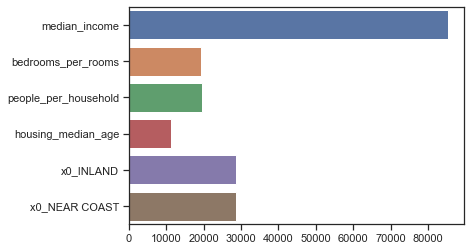

In [265]:
# get absolute values of coefficients
importance = np.abs(lm_pipe.named_steps['lm'].coef_)

sns.barplot(x=importance, 
            y=feature_names);

#### Model 6 - Lasso

##### vorgegebenes Alpha

In diesem Unterkapitel wird eine Lasso Regression für das Modell durchgeführt. Der Wert für alpha wird initial mit 1 belegt.

In [266]:
# Create pipeline with model
lasso_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('lasso', Lasso(alpha=1, max_iter=10000))
                        ])

lasso_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000019AF0E691C0>),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
      

In [267]:
# Metrics trainings set
pred_train = lasso_pipe.predict(X_train)
print('R squared training set:', round(skm.r2_score(y_train, pred_train)*100, 2))
print('MSE training set:', round(skm.mean_squared_error(y_train, pred_train), 2))
print('RMSE training set:', round(skm.mean_squared_error(y_train, pred_train, squared=False), 2))

R squared training set: 74.18
MSE training set: 2816155856.76
RMSE training set: 53067.47


R-squared der Lasso Regression hat sich im Vergleich zur Simple Regression im Modell zuvor nicht verändert. Auch MSE und RMSE sind gleich geblieben. Dies ist auf den initial gewählten, sehr kleinen Wert für alpha von 1 zurückzuführen. Ein geringer Wert in Alpha verändert die Höhe der Koeffizienten im Modell kaum. Daher bleiben auch die Berechnungen des Modells unverändert und somit die Metriken. 

In [268]:
# Metrics validation set
pred = lasso_pipe.predict(X_test)
print('R squared validation set:', round(skm.r2_score(y_test, pred)*100, 2))
print('MSE validation set:', round(skm.mean_squared_error(y_test, pred), 2))
print('RMSE validation set:', round(skm.mean_squared_error(y_test, pred, squared=False), 2))

R squared validation set: 74.67
MSE validation set: 2877369775.47
RMSE validation set: 53641.12


Auch die Metriken des Validation Set haben sich nicht verändert im Vergleich zur Simple Regression.

In [269]:
# Obtain model coefficients and names
print('Koeffizienten und Namen: \n', list(zip(lasso_pipe.named_steps['lasso'].coef_, feature_names)))

Koeffizienten und Namen: 
 [(85226.87228779327, 'median_income'), (19376.806990272275, 'bedrooms_per_rooms'), (-19641.750378420238, 'people_per_household'), (11314.128700828936, 'housing_median_age'), (-57290.99849238739, 'x0_INLAND'), (2.77139978999994e-10, 'x0_NEAR COAST')]


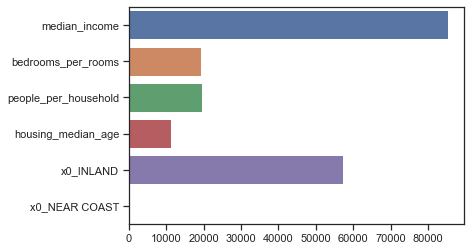

In [270]:
# get absolute values of coefficients
importance = np.abs(lasso_pipe.named_steps['lasso'].coef_)

sns.barplot(x=importance, 
            y=feature_names);

Das Diagramm visualiert die Feature Importance. Je länger der Balken, desto eine höhere Gewichtung bekommt das Feature im Modell. Die Feature Importance ergibt sich auch den Koeffizienten der Features. _median_income_ ist das wichtigste Feature im Modell, wie an dem großen Balken sowie dem Koeffizienten des Features zu erkennen. <br>
Die Ausprägung _NEAR COAST_ der Variablen _ocean_proximity_ wurde von der Lasso Regression aus der Regression entfernt. Dieses Verhalten ist bei Lasso gewünscht. Durch die L1-Regularisierung mit alpha führt der Algorithmus automatisch eine Feature Selection durch. Dabei werden relevante Features durch höhere Koeffizienten stärker gewichtet und unwichtige Features durch kleinere Koeffizienten schäwcher gewichtet bzw. sogar komplett aus dem Modell entfernt, indem der Koeffizient auf den Wert 0 reduziert wird. Durch diese Methode soll ein overfitting des Modells durch zu viele Variablen verhindert werden.

#### k-fold cross validation zur Ermittlung von alpha

In [271]:
from sklearn.linear_model import LassoCV

# Lasso with 5 fold cross-validation
model_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('lassoCV', LassoCV(cv=5, random_state=0, max_iter=10000))
                        ])
# Fit model
model_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000019AF0E691C0>),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
      

In [272]:
#Show best value of penalization chosen by cross validation:
alpha = model_pipe.named_steps['lassoCV'].alpha_
print('Best alpha chosen by cross validation:', alpha)

Best alpha chosen by cross validation: 78.94891231105018


Auf Basis von k-fold cross validation wurde der beste Wert für Alpha ermittelt. Dieser liegt bei 79,59. Bei k-fold cross validation wird das Trainingsdatenset nochmal in k kleinere Datensets unterteilt. Eines Dieser kleineren Datensets wird zur Seite gelegt und das Modell mithilfe der anderen und einem Wert für Alpha trainiert. Anschließend wird mit dem zur Seite gelegten kleinen Datenset eine Validierung des Modells mit den unbekannten Daten durchgeführt. <br>
Dieser Vorgang wird für jedes der k - Datensets für verschiedene Werte von Alpha wiederholt. Das Alpha mit dem besten Ergebnis bei der Validierung wird hier ausgegeben.

Mit dem zuvor ermittelten, besten Wert von Alpha wird nun noch ein finales Lasso Modell auf Basis aller Trainingsdaten trainiert.

In [273]:
# Set best alpha
lasso_best_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('lasso_best', Lasso(alpha=alpha))
                        ])
lasso_best_pipe.fit(X_train, y_train)
lasso_best = lasso_best_pipe.named_steps['lasso_best']

In [274]:
print('Model coefficients and names: \n', list(zip(lasso_best.coef_, feature_names)))

Model coefficients and names: 
 [(85045.084637978, 'median_income'), (19194.892651470986, 'bedrooms_per_rooms'), (-19568.52049548915, 'people_per_household'), (11254.486632101924, 'housing_median_age'), (-57108.04741004523, 'x0_INLAND'), (1.98856656715685e-10, 'x0_NEAR COAST')]


Durch den größeren Wert von Alpha wurden die Koeffizienten der einzelnen Features etwas verkleinert. _median_income_ hatte zuvor beispielsweise einen Wert von 85260,00. Nun liegt der Wert bei 85079,34. 

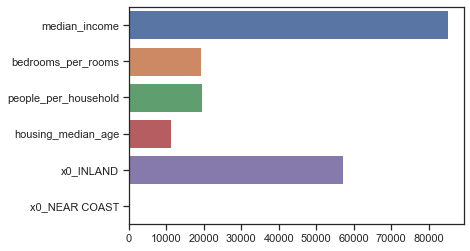

In [275]:
# get absolute values of coefficients
importance = np.abs(lasso_best.coef_)

sns.barplot(x=importance, 
            y=feature_names);

An der Reihenfolge der Feature Importance hat sich durch die Veränderung von Alpha wenig verändert.

In [276]:
# Metrics trainings set
pred_train = lasso_best_pipe.predict(X_train)
print('R squared training set:', round(skm.r2_score(y_train, pred_train)*100, 2))
print('MSE training set:', round(skm.mean_squared_error(y_train, pred_train), 2))
print('RMSE training set:', round(skm.mean_squared_error(y_train, pred_train, squared=False), 2))

R squared training set: 74.18
MSE training set: 2816210527.95
RMSE training set: 53067.98


In [277]:
# Metrics tests set
pred = lasso_best_pipe.predict(X_test)
print('R squared validation set:', round(skm.r2_score(y_test, pred)*100, 2))
print('MSE validation set:', round(skm.mean_squared_error(y_test, pred), 2))
print('RMSE validation set:', round(skm.mean_squared_error(y_test, pred, squared=False), 2))

R squared validation set: 74.67
MSE validation set: 2877619408.17
RMSE validation set: 53643.45


Da sich die Koeffizienten durch den neuen Wert von Alpha kaum verändert haben, sind auch die Kennzahlen zur Performance Messung des Modells unverändert. 

#### Model 7 - Natural Splines

In diesem Modell wird eine scikit learn spline in Kombination mit einer Data Preprocessing Pipeline trainiert.

In [278]:
# use a spline wit 4 knots and 3 degrees with a ridge regressions
spline = make_pipeline(SplineTransformer(n_knots=4, degree=3), 
                       Ridge(alpha=1))

# Integrate Preprocessor Pipeline
spline_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('spline', spline)
                        ])
                     
spline_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000019AF0E691C0>),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
      

In [279]:
# Metrics trainings set
pred_train = spline_pipe.predict(X_train)
print('R squared training set:', round(skm.r2_score(y_train, pred_train)*100, 2))
print('MSE training set:', round(skm.mean_squared_error(y_train, pred_train), 2))
print('RMSE training set:', round(skm.mean_squared_error(y_train, pred_train, squared=False), 2))

R squared training set: 75.09
MSE training set: 2716528957.34
RMSE training set: 52120.33


In [280]:
# Metrics tests set
pred = spline_pipe.predict(X_test)
print('R squared validation set:', round(skm.r2_score(y_test, pred)*100, 2))
print('MSE validation set:', round(skm.mean_squared_error(y_test, pred), 2))
print('RMSE validation set:', round(skm.mean_squared_error(y_test, pred, squared=False), 2))

R squared validation set: 75.52
MSE validation set: 2781732015.02
RMSE validation set: 52742.13


Durch die Verwendung der Spline hat sich das Modell in Bezug auf R-sqared und auch RMSE nochmal verbessert. Das Modell deckt nun knapp 76% der Varianz ab und die durchschnittliche Abweichung der tatsächlichen Werten zu den berechneten Werten beträgt knapp 51000$.

C:\Users\Admin\AppData\Local\Temp/ipykernel_9496/3121680389.py:2: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



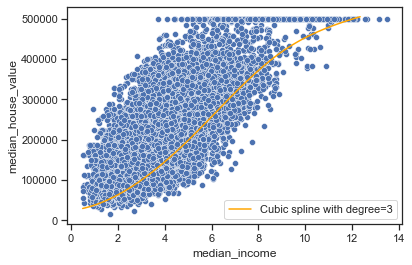

In [281]:
# Create observations
xp = pd.DataFrame(data=np.linspace(X_test.min(),X_test.max(), 100), columns = X_train.drop(['ocean_proximity'], axis=1).columns)
xp = xp.assign(ocean_proximity=lambda xp: 'INLAND')


# Make some predictions
pred_new = spline_pipe.predict(xp)

# plot
sns.scatterplot(x=X_train['median_income'], y=y_train)

plt.plot(xp['median_income'], pred_new, label='Cubic spline with degree=3', color='orange')
plt.legend();

## Evaluierung der besten 2 Modelle mit Test Datenset

In diesem Kapitel wird eine Evaluierung der zwei besten Modellen mithilfe der zu Beginn beiseite gelegten Testdaten durchgeführt.<br>
Zunächst müssen die Testdaten transformiert werden, sodass sie in gleicher Form wie die Trainingsdaten vorliegen und von den Modellen verwendet werden können.

In [346]:
# write out a dict with the mapping of old to new
remap_cat_dict = {
    'NEAR OCEAN': 'NEAR COAST',
    'NEAR BAY': 'NEAR COAST',
    'INLAND': 'INLAND',
    '<1H OCEAN': 'NEAR COAST',
    'ISLAND' : 'NEAR COAST'}

test_dataset.ocean_proximity = test_dataset.ocean_proximity.map(remap_cat_dict).astype('category')

In [347]:
y_test = test_dataset['median_house_value']

X_test = test_dataset[['median_income', 'ocean_proximity', 'bedrooms_per_rooms', 'people_per_household', 'housing_median_age']]

### Evaluation Statsmodels OLS lm2

In [348]:
# Metrics tests set
X_test = X_test.assign(pred_test1=lambda X_test: lm2.predict(X_test))
r2_test1 = round(skm.r2_score(y_test, X_test.pred_test1)*100, 2)
print('R squared Statsmodels OLS with Test Set:', r2_test1)
print('MSE Statsmodels OLS with Test Set:', round(skm.mean_squared_error(y_test, X_test.pred_test1), 2))
print('RMSE Statsmodels OLS with Test Set:', round(skm.mean_squared_error(y_test, X_test.pred_test1, squared=False), 2))

R squared Statsmodels OLS with Test Set: -2.13
MSE Statsmodels OLS with Test Set: 13381618868.21
RMSE Statsmodels OLS with Test Set: 115678.95


R-squared ist in Model lm2 negativ. Somit generalisiert das Modell schlecht auf unbekannte Testdaten und stellt sogar eine Verschlechterung im Vergleich zur Verwendung des Durchschnitts als Modell dar. <br>
Grund dafür könnte ein Overfitting während dem Modellierungsprozess sein. <br>
Root Mean Squared Error und somit eine durchschnittliche Abweichung von tatsächlichem und berechnetem _median_house_value_ in Höhe von 115678,95$ ist ebenso kein zufriedenstellendes Ergebnis.

Die berechneten Werte sollen in einem Scatterplot den tatsächlichen Werten gegenübergestellt werden. Aufgrund der Datenmenge sollen nur einige Datensätze visualisiert werden. Mithilfe eines Data Splittings werden zufällig einige Datenpunkte ausgewählt.

In [349]:
X_notplot, X_plot, y_notplot, y_plot = train_test_split(X_test, y_test, test_size=0.1, random_state=10)

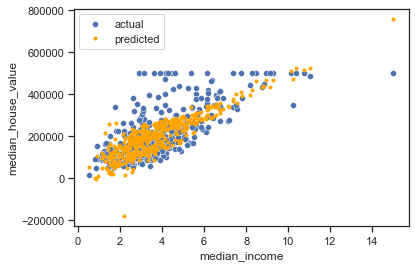

In [350]:
# plot
sns.scatterplot(x=X_plot['median_income'], y=y_plot, label='actual')

plt.plot(X_plot['median_income'], X_plot['pred_test1'], label='predicted', color='orange', marker='.', linestyle='')
plt.legend();

Im Plot ist zu erkennen, dass bei bei einem _median_income_ von 2 einen Datenpunkt gibt, dessen _median_house_value_ negativ geschätzt wurde. Dieser Wert ist unplausibel, da ein Haus keinen negativen Wert hat. <br>
Den Koeffizienten des Modells lm2 ist zu entnehmen, dass nur das Feature _people_per_household_ eine negative Abhängigkeit auf _median_house_value_ hat. Die Ursache für einen negativen Wert wird also durch einen hohen Wert im Feature _people_per_household_ verursacht.

In [351]:
lm2.params

Intercept                        -55841.725014
ocean_proximity[T.NEAR COAST]     57312.739989
median_income                     48796.057520
bedrooms_per_rooms               368968.477487
people_per_household             -25917.607221
housing_median_age                  924.724553
dtype: float64

In [352]:
test_dataset.loc[test_dataset['people_per_household'] > 100]

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
13034    -121.15     38.69                  52          240              44   

       population  households  median_income  median_house_value  \
13034        6675          29         6.1359            225000.0   

      ocean_proximity  people_per_household  rooms_per_household  \
13034          INLAND            230.172414             8.275862   

       bedrooms_per_people  bedrooms_per_rooms  
13034             0.006592            0.183333

Tatsächlich existiert ein Datensatz mit über 100 _people_per_household_. Dieser ist vermutlich für den negativen R-squared Wert verantwortlich. Daher wird dieser testweise entfernt und R-squared erneut berechnet.

In [353]:
X_test2 = X_test.drop(13034)
y_test2 = y_test.drop(13034)

In [354]:
# Metrics tests set
X_test2 = X_test2.assign(pred_test1=lambda X_test2: lm2.predict(X_test2))
r2_test1 = round(skm.r2_score(y_test2, X_test2.pred_test1)*100, 2)
print('R squared Statsmodels OLS with Test Set:', r2_test1)
print('MSE Statsmodels OLS with Test Set:', round(skm.mean_squared_error(y_test2, X_test2.pred_test1), 2))
print('RMSE Statsmodels OLS with Test Set:', round(skm.mean_squared_error(y_test2, X_test2.pred_test1, squared=False), 2))

R squared Statsmodels OLS with Test Set: 61.37
MSE Statsmodels OLS with Test Set: 5063025615.54
RMSE Statsmodels OLS with Test Set: 71154.94


Wie vermutet, lag der Grund für den negativen Wert in diesem Ausreiser.
Jedoch darf auf den Testdaten gemäß der Literatur keine EDA oder Feature Engineering betrieben werden. <br>
Das Modell lm2 ist daher kein gutes Modell, welches ausreichend unbekannte Daten generalisiert.

### Evaluation Scikit Learn Spline

In [355]:
#Calculate R2
X_test = X_test.assign(pred_test2=lambda X_test: spline_pipe.predict(X_test))
r2_test = round(skm.r2_score(y_test, X_test.pred_test2)*100, 2)
print('R squared test set:', r2_test)
mse_test =skm.mean_squared_error(y_test, X_test.pred_test2)
print('MSE test set', round(mse_test, 2))
print('RMSE Statsmodels OLS with Test Set:', round(skm.mean_squared_error(y_test, X_test.pred_test2, squared=False), 2))

R squared test set: 65.25
MSE test set 4552968088.14
RMSE Statsmodels OLS with Test Set: 67475.69


Dieses Modell berechnet aus dem kompletten Test Datenset einen zufriedenstellenden Wert für R-squared. <br>
Auch RMSE mit einem Wert von 67475,69$ ist in Ordnung. 

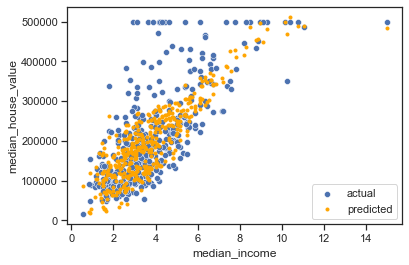

In [77]:
# plot
sns.scatterplot(x=X_plot['median_income'], y=y_plot, label='actual')

plt.plot(X_plot['median_income'], X_plot['pred_test2'], label='predicted', color='orange', marker='.', linestyle='')
plt.legend();

Den Analysen entsprechend ist das beste Modell ist die Spline von Scikit Learn mit einem R-squared der Testdaten von 65,25%. <br>
Gemäß dem Data-Science Lifecycle würde dieses Modell jetzt deployed werden. Dieser Schritt wird allerdings nicht mehr im Rahmen dieses Projekts durchgeführt.